### Final Project: GA Data Science (aus_dat15) - Laurindo Garcia

## Data Model Prototype

# Correlations between demographic and socio-economic factors and incidence of Covid 19 infection and mortality in U.S. Counties

#### Objective
Gain a greater understanding of the relationship between race/ethnicity, gender, poverty and severe health conditions and Covid 19 morbidity and mortality.
Apply skills recently acquired via part-time Data Science course at General Assembly Australia.

#### Method
1. Source data on race/ethnicity, gender, poverty and severe health conditions and Covid 19 morbidity and mortality at the U.S county level
2. Clean and pre-process data according to unique identifiers
3. Conduct exploratory data analysis
4. Test hypothesis that no relationship exists between features using statistical regression (Ordinary Least Squares).
5. Test hypothesis that features with highest importance are unable to predict Covid 19 morbidity and mortality using machine learning (Random Forest).
6. Visualise findings: a) Highly correlated features and possible Simpsons Paradox; b) outcomes of machine learning.
7. Articulate conclusions and next steps

## Source & Clean Data

The following datasets were collected:
1. Covid 19 Morbidity by U.S Count (USA Facts/U.S CDC, 2020): timeseries from 22/01/2020 to 31/07/2020 
2. Covide 19 Mortality by U.S. County (USA Facts/U.S. CDC, 2020): timeseries from 22/01/2020 to 31/07/2020
3. Poverty Universe, All ages, by U.S County (SAIPE, U.S Census, 2019)
4. Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin (U.S Census, 2019)
5. Severe COVID-19 Health Risk Index by U.S County (Policy Map/NY Times/2017 SMART-BRFSS, U.S CDC, 2017) 

In [1]:
import pandas as pd

### Covid 19 Cases by County (USA Facts/CDC)

For most states, USAFacts directly collects the daily county-level cumulative totals of positive cases and deaths from a table, dashboard, or PDF on the state public health website. This data is compiled either through scraping or manual entry. The underlying data is available for download below the US county map and has helped government agencies like the Centers for Disease Control and Prevention in its nationwide efforts.

REFERENCES:
1. https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

Time-series data was collected and aggregated to establish total Covid 19 morbidity by U.S county for the model period (1/22-31/07/2020)

In [2]:
covid_cases = pd.read_csv("data/covid_confirmed_usafacts_200803.csv")

In [3]:
covid_cases.head()

countyFIPS            County Name State  stateFIPS  1/22/20  1/23/20  \
0           0  Statewide Unallocated    AL          1        0        0   
1        1001         Autauga County    AL          1        0        0   
2        1003         Baldwin County    AL          1        0        0   
3        1005         Barbour County    AL          1        0        0   
4        1007            Bibb County    AL          1        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/23/20  7/24/20  7/25/20  \
0        0        0        0        0  ...        0        0        0   
1        0        0        0        0  ...      905      921      932   
2        0        0        0        0  ...     2461     2513     2662   
3        0        0        0        0  ...      534      539      552   
4        0        0        0        0  ...      289      303      318   

   7/26/20  7/27/20  7/28/20  7/29/20  7/30/20  7/31/20  8/1/20  
0        0        0        0        0        0        0       0  
1      942      965      974      974     1002     1015    1030  
2     2708     2770     2835     2835     3028     3101    3142  
3      562      569      575      575      585      598     602  
4      324      334      337      338      352      363     368  

[5 rows x 197 columns]

Data after 31/07/2020 was dropped from the model

In [4]:
covid_cases_dropped = covid_cases.drop(columns=['8/1/20'])

In [5]:
covid_cases_dropped_only = covid_cases_dropped.iloc[:,-192:]

In [1]:
covid_cases_total = covid_cases_dropped['Total Cases']= covid_cases_dropped.iloc[:, -192:].sum(axis=1)

NameError: name 'covid_cases_dropped' is not defined

Since FIPS county ID was being used as the unique identifier across the data sets, the FIPS data type needed to be converted to strings and aligned across datasets.

In [7]:
covid_cases_filter = covid_cases_dropped.loc[:,["countyFIPS", "County Name", "State", "stateFIPS", "Total Cases"]]
covid_cases_filter["countyFIPS"] = covid_cases_filter["countyFIPS"].astype(str)
print(covid_cases_filter.dtypes)

countyFIPS     object
County Name    object
State          object
stateFIPS       int64
Total Cases     int64
dtype: object


In [8]:
covid_cases_filter['countyFIPS_2d'] = covid_cases_filter['countyFIPS'].str[-3:]
covid_cases_filter['countyFIPS'] = covid_cases_filter['countyFIPS'].astype(str).str.zfill(5)
covid_cases_filter['countyFIPS_2d'] = covid_cases_filter['countyFIPS_2d'].astype(str).str.zfill(3)
covid_cases_filter['stateFIPS'] = covid_cases_filter['stateFIPS'].astype(str).str.zfill(2)
covid_cases_filter = covid_cases_filter.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d", "County Name", "State", "Total Cases"]]

In [9]:
covid_cases_clean = covid_cases_filter.copy()

Rows presenting state level totals were dropped from the model 

In [10]:
covid_cases_clean = covid_cases_clean.loc[covid_cases_clean['County Name'] != "Statewide Unallocated"]
covid_cases_clean

countyFIPS stateFIPS countyFIPS_2d        County Name State  Total Cases
1         01001        01           001     Autauga County    AL        39746
2         01003        01           003     Baldwin County    AL        76970
3         01005        01           005     Barbour County    AL        24625
4         01007        01           007        Bibb County    AL        13636
5         01009        01           009      Blount County    AL        19311
...         ...       ...           ...                ...   ...          ...
3190      56037        56           037  Sweetwater County    WY         7361
3191      56039        56           039       Teton County    WY        13823
3192      56041        56           041       Uinta County    WY         9737
3193      56043        56           043    Washakie County    WY         3104
3194      56045        56           045      Weston County    WY          130

[3145 rows x 6 columns]

Data validation was conducted at each iteration for the purpose of identifying any missing data and ensuring that recent changes to census survey areas were accounted for across all data sets.

In [11]:
test_cases = covid_cases_clean.loc[(covid_cases_clean["countyFIPS"] == "51560")]
test_cases

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, County Name, State, Total Cases]
Index: []

In [12]:
null_data_cases = covid_cases_clean[covid_cases_clean.isnull().any(axis=1)]
null_data_cases

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, County Name, State, Total Cases]
Index: []

### Covid 19 Deaths by County (USA Facts/CDC)

For most states, USAFacts directly collects the daily county-level cumulative totals of positive cases and deaths from a table, dashboard, or PDF on the state public health website. This data is compiled either through scraping or manual entry. The underlying data is available for download below the US county map and has helped government agencies like the Centers for Disease Control and Prevention in its nationwide efforts.

REFERENCES:
1. https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

In [13]:
covid_deaths = pd.read_csv("data/covid_deaths_usafacts_200803.csv")

Time-series data was collected and aggregated to establish total Covid 19 mortality by U.S county for the model period (1/22-31/07/2020). Data after 31/07/2020 was dropped from the model.

In [14]:
covid_deaths_dropped = covid_deaths.drop(columns=['8/1/20'])

In [15]:
covid_deaths_total = covid_deaths_dropped['Total Deaths']= covid_deaths_dropped.iloc[:, -192:].sum(axis=1)

In [16]:
covid_deaths_filter = covid_deaths_dropped.loc[:,["countyFIPS", "County Name", "State", "stateFIPS", "Total Deaths"]]

Since FIPS county ID was being used as the unique identifier across the data sets, the FIPS data type needed to be converted to strings and aligned across datasets.

In [17]:
covid_deaths_filter = covid_deaths_dropped.loc[:,["countyFIPS", "County Name", "State", "stateFIPS", "Total Deaths"]]
covid_deaths_filter["countyFIPS"] = covid_deaths_filter["countyFIPS"].astype(str)
print(covid_deaths_filter.dtypes)

countyFIPS      object
County Name     object
State           object
stateFIPS        int64
Total Deaths     int64
dtype: object


Rows presenting state level totals were dropped from the model

In [18]:
covid_deaths_filter['countyFIPS_2d'] = covid_deaths_filter['countyFIPS'].str[-3:]
covid_deaths_filter['countyFIPS'] = covid_deaths_filter['countyFIPS'].astype(str).str.zfill(5)
covid_deaths_filter['countyFIPS_2d'] = covid_deaths_filter['countyFIPS_2d'].astype(str).str.zfill(3)
covid_deaths_filter['stateFIPS'] = covid_deaths_filter['stateFIPS'].astype(str).str.zfill(2)
covid_deaths_filter = covid_deaths_filter.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d", "County Name", "State", "Total Deaths"]]
covid_deaths_filter

countyFIPS stateFIPS countyFIPS_2d            County Name State  \
0         00000        01           000  Statewide Unallocated    AL   
1         01001        01           001         Autauga County    AL   
2         01003        01           003         Baldwin County    AL   
3         01005        01           005         Barbour County    AL   
4         01007        01           007            Bibb County    AL   
...         ...       ...           ...                    ...   ...   
3190      56037        56           037      Sweetwater County    WY   
3191      56039        56           039           Teton County    WY   
3192      56041        56           041           Uinta County    WY   
3193      56043        56           043        Washakie County    WY   
3194      56045        56           045          Weston County    WY   

      Total Deaths  
0                0  
1              909  
2              958  
3              155  
4              103  
...            ...  
3190            34  
3191           101  
3192             0  
3193           291  
3194             0  

[3195 rows x 6 columns]

In [19]:
covid_deaths_clean = covid_deaths_filter.copy()
covid_deaths_clean = covid_deaths_clean.loc[covid_deaths_clean['County Name'] != "Statewide Unallocated"]

Data validation was conducted at each iteration for the purpose of identifying any missing data and ensuring that recent changes to census survey areas were accounted for across all data sets.

In [20]:
covid_deaths_clean.describe()
test_deaths_1 = covid_deaths_clean.loc[(covid_deaths_clean["countyFIPS"] == "15005")]
test_deaths_1

countyFIPS stateFIPS countyFIPS_2d     County Name State  Total Deaths
561      15005        15           005  Kalawao County    HI             0

In [21]:
null_data_deaths = covid_deaths_clean[covid_deaths_clean.isnull().any(axis=1)]
null_data_deaths

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, County Name, State, Total Deaths]
Index: []

In [22]:
covid_deaths_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3146 entries, 1 to 3194
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   countyFIPS     3146 non-null   object
 1   stateFIPS      3146 non-null   object
 2   countyFIPS_2d  3146 non-null   object
 3   County Name    3146 non-null   object
 4   State          3146 non-null   object
 5   Total Deaths   3146 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 172.0+ KB


### Per capital incidence of poverty by U.S county (U.S Census)

The poverty universe is made up of persons for whom the Census Bureau can determine poverty status (either "in poverty" or "not in poverty").

REFERENCES:
1. SAIPE Model Input Data: https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html

Poverty dataframe was constrained to aggregate values for Poverty Universe, All Ages for the period.

In [23]:
poverty = pd.read_csv("data/allpovu.csv")
poverty_all_ages = poverty.loc[:,["State FIPS code", "County FIPS code", "Name", "State Postal Code", "Poverty Universe, All Ages"]]
poverty_all_ages.rename(columns={'State FIPS code': 'stateFIPS', 'County FIPS code': 'countyFIPS_2d'}, inplace=True)
poverty_all_ages

stateFIPS  countyFIPS_2d               Name State Postal Code  \
0             0              0      United States                US   
1             1              0            Alabama                AL   
2             1              1     Autauga County                AL   
3             1              3     Baldwin County                AL   
4             1              5     Barbour County                AL   
...         ...            ...                ...               ...   
3196         56             37  Sweetwater County                WY   
3197         56             39       Teton County                WY   
3198         56             41       Uinta County                WY   
3199         56             43    Washakie County                WY   
3200         56             45      Weston County                WY   

      Poverty Universe, All Ages  
0                    319184033.0  
1                      4763811.0  
2                        55073.0  
3                       215255.0  
4                        21979.0  
...                          ...  
3196                     42205.0  
3197                     22888.0  
3198                     20135.0  
3199                      7735.0  
3200                      6595.0  

[3201 rows x 5 columns]

Since FIPS county ID was being used as the unique identifier across the data sets, the FIPS data type needed to be converted to strings and aligned across datasets.

In [24]:
poverty_all_ages.rename(columns={'Name': 'County Name', 'State Postal Code': 'State'}, inplace=True)
poverty_clean = poverty_all_ages.copy()
poverty_clean['countyFIPS_2d'] = poverty_clean['countyFIPS_2d'].astype(str).str.zfill(3)
poverty_clean['stateFIPS'] = poverty_clean['stateFIPS'].astype(str).str.zfill(2)
poverty_clean["countyFIPS"] = poverty_clean["stateFIPS"] + poverty_clean["countyFIPS_2d"]

In [25]:
poverty_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stateFIPS                   3201 non-null   object 
 1   countyFIPS_2d               3201 non-null   object 
 2   County Name                 3201 non-null   object 
 3   State                       3201 non-null   object 
 4   Poverty Universe, All Ages  3193 non-null   float64
 5   countyFIPS                  3201 non-null   object 
dtypes: float64(1), object(5)
memory usage: 150.2+ KB


Rows presenting national and state level totals were dropped from the model using a filter via FIPS code

In [26]:
poverty_clean = poverty_clean.loc[poverty_clean['countyFIPS_2d'] != 0]

In [27]:
poverty_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stateFIPS                   3201 non-null   object 
 1   countyFIPS_2d               3201 non-null   object 
 2   County Name                 3201 non-null   object 
 3   State                       3201 non-null   object 
 4   Poverty Universe, All Ages  3193 non-null   float64
 5   countyFIPS                  3201 non-null   object 
dtypes: float64(1), object(5)
memory usage: 175.1+ KB


Data validation at each iteration seeking any missing data and ensuring that recent changes to census survey areas revealed several areas with missing data. After checking with the Covid 19 morbitity and mortality datasets, these areas were were not included. A decision was made to drop the missing data from the poverty dataset. 

In [28]:
null_data_pov = poverty_clean[poverty_clean.isnull().any(axis=1)]
null_data_pov

stateFIPS countyFIPS_2d                                  County Name  \
92          02           201  Prince of Wales-Outer Ketchikan Census Area   
95          02           232            Skagway-Hoonah-Angoon Census Area   
98          02           270                     Wade Hampton Census Area   
100         02           280              Wrangell-Petersburg Census Area   
565         15           005                               Kalawao County   
2465        46           113                               Shannon County   
2969        51           515                                 Bedford city   
2974        51           560                                Clifton Forge   

     State  Poverty Universe, All Ages countyFIPS  
92      AK                         NaN      02201  
95      AK                         NaN      02232  
98      AK                         NaN      02270  
100     AK                         NaN      02280  
565     HI                         NaN      15005  
2465    SD                         NaN      46113  
2969    VA                         NaN      51515  
2974    VA                         NaN      51560

In [29]:
poverty_clean['Poverty Universe, All Ages'] = poverty_clean['Poverty Universe, All Ages'].fillna((poverty_clean['Poverty Universe, All Ages'].mean()))

In [30]:
poverty_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stateFIPS                   3201 non-null   object 
 1   countyFIPS_2d               3201 non-null   object 
 2   County Name                 3201 non-null   object 
 3   State                       3201 non-null   object 
 4   Poverty Universe, All Ages  3201 non-null   float64
 5   countyFIPS                  3201 non-null   object 
dtypes: float64(1), object(5)
memory usage: 175.1+ KB


Changes to census survey areas were accounted for across all data sets and subsequently no further missing data was found in the dataframe.

In [31]:
test_pov = poverty_clean.loc[(poverty_clean["countyFIPS"] == "46102")]
test_pov

stateFIPS countyFIPS_2d           County Name State  \
2459        46           102  Oglala Lakota County    SD   

      Poverty Universe, All Ages countyFIPS  
2459                     14235.0      46102

### County Population by Racial/Ethnic Characteristics 2010-2019 (U.S. Census Bureau)

METHODOLOGY FOR THE UNITED STATES POPULATION ESTIMATES: VINTAGE 2019
Nation, States, Counties, and Puerto Rico – April 1, 2010 to July 1, 2019

Each year, the United States Census Bureau produces and publishes estimates of the population for the
nation, states, counties, state/county equivalents, and Puerto Rico.1 We estimate the resident population for
each year since the most recent decennial census by using measures of population change. The resident
population includes all people currently residing in the United States.

With each annual release of population estimates, the Population Estimates Program revises and updates the
entire time series of estimates from April 1, 2010 to July 1 of the current year, which we refer to as the
vintage year. We use the term “vintage” to denote an entire time series created with a consistent population
starting point and methodology. The release of a new vintage of estimates supersedes any previous series
and incorporates the most up-to-date input data and methodological improvements

REFERENCES:
1. Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2010 to July 1, 2019 (https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html)
2. File Layout: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf

In [32]:
race = pd.read_csv("data/cc-est2019-alldata.csv", encoding = "ISO-8859-1")

After evaluating the raw data, a decision was made to constrain the data to:
1. Data from the most recent vintage year only: 2019;
2. Aggregate racial identity by gender (e.g. "White" identity was aggregrated with "White Alone and Combination" identities, etc. resulting in the following: e.g. race["WA_MALE_TOTAL"] = race.loc[:, ["WA_MALE", "WAC_MALE"].sum())
3. Columns for "Two or More Races" and "Not" identities were dropped due to lack of knowledge on how to distribute back into other identities.

The aggregated groups are as follows:
- W_Male = WA_MALE + WAC_MALE
- W_Female = WA_FEMALE + WAC_FEMALE
- B_Male = BA_MALE + BAC_MALE
- B_Female = BA_FEMALE + BAC_FEMALE
- IA_Male = IA_MALE + IAC_MALE
- IA_Female = IA_FEMALE + IAC_FEMALE
- A_Male = AA_MALE + AAC_MALE 
- A_Female = AA_FEMALE + AAC_FEMALE
- NA_Male = NA_MALE + NAC_MALE 
- NA_Female = NA_FEMALE + NAC_FEMALE

In [33]:
race["WA_MALE_TOTAL"] = race.loc[:, ["WA_MALE", "WAC_MALE"]].sum(axis=1)
race["WA_FEMALE_TOTAL"] = race.loc[:, ["WA_FEMALE", "WAC_FEMALE"]].sum(axis=1)
race["BA_MALE_TOTAL"] = race.loc[:, ["BA_MALE", "BAC_MALE"]].sum(axis=1)
race["BA_FEMALE_TOTAL"] = race.loc[:, ["BA_FEMALE", "BAC_FEMALE"]].sum(axis=1)
race["IA_MALE_TOTAL"] = race.loc[:, ["IA_MALE", "IAC_MALE"]].sum(axis=1)
race["IA_FEMALE_TOTAL"] = race.loc[:, ["IA_FEMALE", "IAC_FEMALE"]].sum(axis=1)
race["AA_MALE_TOTAL"] = race.loc[:, ["AA_MALE", "AAC_MALE"]].sum(axis=1)
race["AA_FEMALE_TOTAL"] = race.loc[:, ["AA_FEMALE", "AAC_FEMALE"]].sum(axis=1)
race["NA_MALE_TOTAL"] = race.loc[:, ["NA_MALE", "NAC_MALE"]].sum(axis=1)
race["NA_FEMALE_TOTAL"] = race.loc[:, ["NA_FEMALE", "NAC_FEMALE"]].sum(axis=1)

In [34]:
race["YEAR"] = race["YEAR"].astype(int)
race

SUMLEV  STATE  COUNTY   STNAME         CTYNAME  YEAR  AGEGRP  TOT_POP  \
0           50      1       1  Alabama  Autauga County     1       0    54571   
1           50      1       1  Alabama  Autauga County     1       1     3579   
2           50      1       1  Alabama  Autauga County     1       2     3991   
3           50      1       1  Alabama  Autauga County     1       3     4290   
4           50      1       1  Alabama  Autauga County     1       4     4290   
...        ...    ...     ...      ...             ...   ...     ...      ...   
716371      50     56      45  Wyoming   Weston County    12      14      499   
716372      50     56      45  Wyoming   Weston County    12      15      352   
716373      50     56      45  Wyoming   Weston County    12      16      229   
716374      50     56      45  Wyoming   Weston County    12      17      198   
716375      50     56      45  Wyoming   Weston County    12      18      200   

        TOT_MALE  TOT_FEMALE  ...  WA_MALE_TOTAL  WA_FEMALE_TOTAL  \
0          26569       28002  ...          42928            44393   
1           1866        1713  ...           2890             2684   
2           2001        1990  ...           3091             3109   
3           2171        2119  ...           3352             3301   
4           2213        2077  ...           3292             3209   
...          ...         ...  ...            ...              ...   
716371       280         219  ...            514              409   
716372       180         172  ...            349              339   
716373       107         122  ...            212              240   
716374        82         116  ...            161              230   
716375        72         128  ...            141              251   

        BA_MALE_TOTAL  BA_FEMALE_TOTAL  IA_MALE_TOTAL  IA_FEMALE_TOTAL  \
0                9263            10436            396              453   
1                 767              679             28               21   
2                 824              777             41               27   
3                 884              842             44               39   
4                1027              868             35               27   
...               ...              ...            ...              ...   
716371              1                2              7                2   
716372              0                1              4                2   
716373              0                0              2                4   
716374              0                0              2                2   
716375              0                0              3                3   

        AA_MALE_TOTAL  AA_FEMALE_TOTAL  NA_MALE_TOTAL  NA_FEMALE_TOTAL  
0                 500              693             71               55  
1                  47               43              4                1  
2                  49               63              4                7  
3                  55               55              8                6  
4                  64               45             10                7  
...               ...              ...            ...              ...  
716371             38               25              0                0  
716372              7                2              0                0  
716373              0                0              0                0  
716374              1                0              0                0  
716375              0                2              0                0  

[716376 rows x 90 columns]

Dataframe is constrained to YEAR: 12 = 7/1/2019 & AGEGRP: 0 = Total

In [35]:
race_current = race.loc[(race['YEAR'] == 12) & (race['AGEGRP'] == 0)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 209 to 716357
Data columns (total 90 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SUMLEV           3142 non-null   int64 
 1   STATE            3142 non-null   int64 
 2   COUNTY           3142 non-null   int64 
 3   STNAME           3142 non-null   object
 4   CTYNAME          3142 non-null   object
 5   YEAR             3142 non-null   int64 
 6   AGEGRP           3142 non-null   int64 
 7   TOT_POP          3142 non-null   int64 
 8   TOT_MALE         3142 non-null   int64 
 9   TOT_FEMALE       3142 non-null   int64 
 10  WA_MALE          3142 non-null   int64 
 11  WA_FEMALE        3142 non-null   int64 
 12  BA_MALE          3142 non-null   int64 
 13  BA_FEMALE        3142 non-null   int64 
 14  IA_MALE          3142 non-null   int64 
 15  IA_FEMALE        3142 non-null   int64 
 16  AA_MALE          3142 non-null   int64 
 17  AA_FEMALE        3142 non-nul

In [36]:
race_current.loc[:,["STATE", "COUNTY", "STNAME", "CTYNAME", "TOT_POP", "WA_MALE_TOTAL", "WA_FEMALE_TOTAL"
               , "BA_MALE_TOTAL", "BA_FEMALE_TOTAL", "IA_MALE_TOTAL", "IA_FEMALE_TOTAL"
               , "AA_MALE_TOTAL", "AA_FEMALE_TOTAL", "NA_MALE_TOTAL", "NA_FEMALE_TOTAL"]]

STATE  COUNTY   STNAME            CTYNAME  TOT_POP  WA_MALE_TOTAL  \
209         1       1  Alabama     Autauga County    55869          42250   
437         1       3  Alabama     Baldwin County   223234         191540   
665         1       5  Alabama     Barbour County    24686          12906   
893         1       7  Alabama        Bibb County    22394          17635   
1121        1       9  Alabama      Blount County    57826          54866   
...       ...     ...      ...                ...      ...            ...   
715445     56      37  Wyoming  Sweetwater County    42343          41325   
715673     56      39  Wyoming       Teton County    23464          23328   
715901     56      41  Wyoming       Uinta County    20226          19698   
716129     56      43  Wyoming    Washakie County     7805           7602   
716357     56      45  Wyoming      Weston County     6927           6867   

        WA_FEMALE_TOTAL  BA_MALE_TOTAL  BA_FEMALE_TOTAL  IA_MALE_TOTAL  \
209               43920          10751            12270            395   
437              202761          19832            21115           2721   
665               11608          12743            11280            285   
893               16976           5951             3719            159   
1121              56713           1174             1080            592   
...                 ...            ...              ...            ...   
715445            38927            828              640            881   
715673            21591            248              181            310   
715901            19209            199              186            391   
716129             7321             80               57            169   
716357             6211             87               60            211   

        IA_FEMALE_TOTAL  AA_MALE_TOTAL  AA_FEMALE_TOTAL  NA_MALE_TOTAL  \
209                 446            727              879             87   
437                2624           2337             3394            254   
665                 182            127              141             72   
893                 151             72               73             50   
1121                598            232              265            102   
...                 ...            ...              ...            ...   
715445              801            516              619             97   
715673              272            358              573             63   
715901              402            123              180             54   
716129              198             66              102             13   
716357              155             78              178              8   

        NA_FEMALE_TOTAL  
209                  75  
437                 267  
665                  41  
893                  16  
1121                 62  
...                 ...  
715445               99  
715673               43  
715901               44  
716129               13  
716357                2  

[3142 rows x 15 columns]

In [37]:
race_current.describe()

SUMLEV        STATE       COUNTY    YEAR  AGEGRP       TOT_POP  \
count  3142.0  3142.000000  3142.000000  3142.0  3142.0  3.142000e+03   
mean     50.0    30.280076   103.572884    12.0     0.0  1.044683e+05   
std       0.0    15.144339   107.704060     0.0     0.0  3.334567e+05   
min      50.0     1.000000     1.000000    12.0     0.0  8.600000e+01   
25%      50.0    18.000000    35.000000    12.0     0.0  1.090250e+04   
50%      50.0    29.000000    79.000000    12.0     0.0  2.572600e+04   
75%      50.0    45.000000   133.000000    12.0     0.0  6.807275e+04   
max      50.0    56.000000   840.000000    12.0     0.0  1.003911e+07   

           TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE  ...  \
count  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03  ...   
mean   5.145045e+04  5.301789e+04  3.952652e+04  4.020683e+04  ...   
std    1.638677e+05  1.696276e+05  1.179341e+05  1.190460e+05  ...   
min    4.100000e+01  4.500000e+01  1.300000e+01  1.100000e+01  ...   
25%    5.459750e+03  5.407250e+03  4.544250e+03  4.461750e+03  ...   
50%    1.286900e+04  1.282850e+04  1.094450e+04  1.101950e+04  ...   
75%    3.415225e+04  3.451250e+04  2.910775e+04  2.975875e+04  ...   
max    4.949041e+06  5.090066e+06  3.552806e+06  3.545503e+06  ...   

       WA_MALE_TOTAL  WA_FEMALE_TOTAL  BA_MALE_TOTAL  BA_FEMALE_TOTAL  \
count   3.142000e+03     3.142000e+03   3.142000e+03     3.142000e+03   
mean    8.033665e+04     8.171576e+04   1.408558e+04     1.528941e+04   
std     2.401430e+05     2.424334e+05   5.646954e+04     6.512335e+04   
min     2.900000e+01     3.000000e+01   0.000000e+00     0.000000e+00   
25%     9.183000e+03     8.992500e+03   2.190000e+02     1.482500e+02   
50%     2.210150e+04     2.229450e+04   1.278500e+03     8.390000e+02   
75%     5.877825e+04     6.018950e+04   6.424000e+03     6.014000e+03   
max     7.240650e+06     7.229593e+06   1.140998e+06     1.362219e+06   

       IA_MALE_TOTAL  IA_FEMALE_TOTAL  AA_MALE_TOTAL  AA_FEMALE_TOTAL  \
count    3142.000000      3142.000000   3.142000e+03     3.142000e+03   
mean     1771.046467      1772.443030   6.459161e+03     7.024877e+03   
std      6577.875055      6677.061211   4.455279e+04     4.892902e+04   
min         0.000000         0.000000   0.000000e+00     0.000000e+00   
25%       121.000000       115.000000   6.500000e+01     7.700000e+01   
50%       325.000000       300.000000   2.040000e+02     2.320000e+02   
75%      1008.750000       971.750000   9.527500e+02     1.083000e+03   
max    188264.000000    185298.000000   1.529785e+06     1.731856e+06   

       NA_MALE_TOTAL  NA_FEMALE_TOTAL  
count    3142.000000      3142.000000  
mean      387.793125       382.213558  
std      3681.779723      3625.889024  
min         0.000000         0.000000  
25%         9.000000         8.000000  
50%        28.000000        25.000000  
75%       108.750000       100.000000  
max    171165.000000    166656.000000  

[8 rows x 88 columns]

Since FIPS county ID was being used as the unique identifier across the data sets, the FIPS data type needed to be converted to strings and aligned across datasets.

In [38]:
race_current.rename(columns={'CTYNAME': 'County Name'}, inplace=True)
race_current.rename(columns={'STATE': 'stateFIPS'}, inplace=True)
race_current.rename(columns={'COUNTY': 'countyFIPS_2d'}, inplace=True)

/Users/laurindogarcia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [39]:
race_current['countyFIPS_2d'] = race_current['countyFIPS_2d'].astype(str).str.zfill(3)
race_current['stateFIPS'] = race_current['stateFIPS'].astype(str).str.zfill(2)
race_current["countyFIPS"] = race_current["stateFIPS"] + race_current["countyFIPS_2d"]

<ipython-input-39-7ad2b8e29a73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_current['countyFIPS_2d'] = race_current['countyFIPS_2d'].astype(str).str.zfill(3)
<ipython-input-39-7ad2b8e29a73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_current['stateFIPS'] = race_current['stateFIPS'].astype(str).str.zfill(2)
<ipython-input-39-7ad2b8e29a73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Data validation was conducted at each iteration for the purpose of identifying any missing data and ensuring that recent changes to census survey areas were accounted for across all data sets.

In [40]:
test_race_sd = race_current.loc[(race_current["countyFIPS"] == "46102")]
test_race_sd

SUMLEV stateFIPS countyFIPS_2d        STNAME           County Name  \
550145      50        46           102  South Dakota  Oglala Lakota County   

        YEAR  AGEGRP  TOT_POP  TOT_MALE  TOT_FEMALE  ...  WA_FEMALE_TOTAL  \
550145    12       0    14177      6961        7216  ...              844   

        BA_MALE_TOTAL  BA_FEMALE_TOTAL  IA_MALE_TOTAL  IA_FEMALE_TOTAL  \
550145             94               69          12904            13475   

        AA_MALE_TOTAL  AA_FEMALE_TOTAL  NA_MALE_TOTAL  NA_FEMALE_TOTAL  \
550145             29               37             12               13   

        countyFIPS  
550145       46102  

[1 rows x 91 columns]

In [41]:
race_clean = race_current.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d", "STNAME", "County Name", "TOT_POP", "WA_MALE_TOTAL", "WA_FEMALE_TOTAL"
               , "BA_MALE_TOTAL", "BA_FEMALE_TOTAL", "IA_MALE_TOTAL", "IA_FEMALE_TOTAL"
               , "AA_MALE_TOTAL", "AA_FEMALE_TOTAL", "NA_MALE_TOTAL", "NA_FEMALE_TOTAL"]]

In [42]:
null_data_race = race_clean[race_clean.isnull().any(axis=1)]
null_data_race

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, STNAME, County Name, TOT_POP, WA_MALE_TOTAL, WA_FEMALE_TOTAL, BA_MALE_TOTAL, BA_FEMALE_TOTAL, IA_MALE_TOTAL, IA_FEMALE_TOTAL, AA_MALE_TOTAL, AA_FEMALE_TOTAL, NA_MALE_TOTAL, NA_FEMALE_TOTAL]
Index: []

In [43]:
test_race = race_clean.loc[(race_clean["countyFIPS"] == "46102")]
test_race

countyFIPS stateFIPS countyFIPS_2d        STNAME           County Name  \
550145      46102        46           102  South Dakota  Oglala Lakota County   

        TOT_POP  WA_MALE_TOTAL  WA_FEMALE_TOTAL  BA_MALE_TOTAL  \
550145    14177            889              844             94   

        BA_FEMALE_TOTAL  IA_MALE_TOTAL  IA_FEMALE_TOTAL  AA_MALE_TOTAL  \
550145               69          12904            13475             29   

        AA_FEMALE_TOTAL  NA_MALE_TOTAL  NA_FEMALE_TOTAL  
550145               37             12               13

### Incidence of Pre-existing Conditions & Coverage of Flu Vaccine

After attempting to use the source data on Pre-Existing Health Conditions from the U.S. CDC (BRFSS/SMART CITIES 2017),  its usability was found to be complex and beyond the capability of this model. As an alternative the Severe COVID-19 Health Risk Index from Policy Map/New York Times was found. Severe COVID-19 Health Risk Index also used data BRFSS/SMART CITIES 2017 as a basis for their findings. 

People of any age with the following conditions are at increased risk of severe illness from COVID-19 (according to CDC, 17 July 17 2020:

PolicyMap worked with journalists at the New York Times to create this index assessing a county’s relative risk of its population developing severe COVID-19 symptoms. The index represents the relative risk for a high proportion of residents in each county to develop serious health complications from COVID-19 because of underlying health conditions identified by the CDC as contributing to a person’s risk of developing severe symptoms from the virus. These conditions include COPD, heart disease, high blood pressure, diabetes, and obesity.

Estimates of COPD, heart disease, high blood pressure, and diabetes and obesity prevalence at the tract and ZCTA level are from PolicyMap’s Health Outcome Estimates. Estimates of diabetes and obesity prevalence at the county level are from the CDC’s U.S. Diabetes Surveillance System.

Normalized scores were then converted to percentiles and z scores for easier interpretation. Percentiles rank counties from the lowest score to the highest on a scale of 0 to 100, where a score of 50 represents the median value. A county’s z score shows how many standard deviations above or below the average a county’s risk level falls. A score of 0.6, for example, would mean that the county has a higher risk than average, but is still within one standard deviation of the average and is therefore not unusually high. Risk categories from very low to very high are assigned based on z scores.

Constrained features to the following (according to CDC advisory 28 July, 2020):
- Serious heart conditions, such as heart failure, coronary artery disease, or cardiomyopathies (CVDINFR4, CVDCRHD4)
- Cancer (CHCOCNCR)
- Chronic kidney disease (CHCKDNY)
- COPD (CHCCOPD1)
- Obesity (BMI> 30) ( _BMI5CAT value 4; not available at county level)
- Sickle cell disease (not available)
- Solid organ transplantation 
- Type 2 diabetes mellitus (proxy; taking insulin: INSULIN)


Proxy Prevention Coverage
- Adult flu shot/spray past 12 mos (FLUSHOT6)


REFERENCES:
1. Covid 19 People with Certain Medical Conditions https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-with-medical-conditions.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fneed-extra-precautions%2Fgroups-at-higher-risk.html
2. Centers for Disease Control and Prevention (CDC). Behavioral Risk Factor Surveillance System Survey Data. Atlanta, Georgia: U.S. Department of Health and Human Services, Centers for Disease Control and Prevention, 2017.: https://www.cdc.gov/brfss/smart/smart_2017.html
3. Evidence used to update the list of underlying medical conditions that increase a person’s risk of severe illness from COVID-19: https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/evidence-table.html
4. PolicyMap Severe COVID-19 Health Risk Index: https://www.policymap.com/download-covid19-data/


Data from the 'Severe COVID-19 Health Risk Index' was constrained to index percentile (score out of 100) and risk category (categorical data).

In [46]:
preexisting = pd.read_csv("data/risk_clean6.csv")

In [47]:
preexisting

countyFIPS  stateFIPS  countyFIPS_2d  index_percentile index_category
0           1001          1              1             65.42  Above Average
1           1003          1              3             68.39  Above Average
2           1005          1              5             97.09           High
3           1007          1              7             83.36  Above Average
4           1009          1              9             81.75  Above Average
...          ...        ...            ...               ...            ...
3138       56037         56             37             10.42            Low
3139       56039         56             39              2.94       Very low
3140       56041         56             41             27.13  Below Average
3141       56043         56             43             32.76  Below Average
3142       56045         56             45             33.16  Below Average

[3143 rows x 5 columns]

In [48]:
print(preexisting.dtypes)

countyFIPS            int64
stateFIPS             int64
countyFIPS_2d         int64
index_percentile    float64
index_category       object
dtype: object


In [49]:
preexisting.describe()

countyFIPS    stateFIPS  countyFIPS_2d  index_percentile
count   3143.000000  3143.000000    3143.000000       3143.000000
mean   30390.372574    30.286669     103.703786         48.120646
std    15164.780323    15.146439     107.936692        181.451891
min     1001.000000     1.000000       1.000000      -9999.000000
25%    18178.000000    18.000000      35.000000         27.020000
50%    29177.000000    29.000000      79.000000         51.380000
75%    45082.000000    45.000000     133.000000         75.470000
max    56045.000000    56.000000     840.000000        100.000000

As with the other data sets, the unique identifier (FIPS County ID) needed to be converted to strings and aligned across datasets.

In [3]:
preexisting.rename(columns={'index_percentile': 'Risk Index'}, inplace=True)

NameError: name 'preexisting' is not defined

In [51]:
preexisting["countyFIPS"] = preexisting["countyFIPS"].astype(str).str.zfill(5)
preexisting["stateFIPS"] = preexisting["stateFIPS"].astype(str).str.zfill(2)
preexisting["countyFIPS_2d"] = preexisting["countyFIPS_2d"].astype(str).str.zfill(3)

# preexisting["Risk Index"] = preexisting["Risk Index"].astype(str)

Data validation was conducted at each iteration for the purpose of identifying any missing data and ensuring that recent changes to census survey areas were accounted for across all data sets.

In [52]:
null_data_preexisting = preexisting[preexisting.isnull().any(axis=1)]
null_data_preexisting

countyFIPS stateFIPS countyFIPS_2d  Risk Index index_category
2916      51515        51           515     -9999.0            NaN

In [53]:
preexisting_clean = preexisting.dropna()

In [54]:
null_data_preexisting = preexisting_clean[preexisting_clean.isnull().any(axis=1)]
null_data_preexisting

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, Risk Index, index_category]
Index: []

In [55]:
test_preexisting = preexisting_clean.loc[(preexisting_clean["countyFIPS"] == "1001")]
test_preexisting

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, Risk Index, index_category]
Index: []

In [56]:
test_preexisting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   countyFIPS      0 non-null      object 
 1   stateFIPS       0 non-null      object 
 2   countyFIPS_2d   0 non-null      object 
 3   Risk Index      0 non-null      float64
 4   index_category  0 non-null      object 
dtypes: float64(1), object(4)
memory usage: 0.0+ bytes


### Flu Coverage (CDC Wonder)? 

A stretch goal to include a feature on coverage seasonal flu vaccine across U.S. counties was assessed and subsequently deferred for future consideration.

## Merging Dataframes

A hierarchy among the datasets was established to guide pre-processing and provide clarity when troubleshooting conflicts that arise in data merges. 

The Covid 19 Morbidity dataset was used as the root dataset against which all the other datasets had to align.  

### Merging Covid 19 Morbidity with Covid 19 Mortality

In [57]:
merge_cases_death = covid_cases_clean.merge(covid_deaths_clean, on=["stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

The merged data set was tested for any missing values.

In [58]:
merge_cases_death.info()
null_data_m_1 = merge_cases_death[merge_cases_death.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3145 entries, 0 to 3144
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   countyFIPS     3145 non-null   object
 1   stateFIPS      3145 non-null   object
 2   countyFIPS_2d  3145 non-null   object
 3   County Name_x  3145 non-null   object
 4   State_x        3145 non-null   object
 5   Total Cases    3145 non-null   int64 
 6   County Name_y  3145 non-null   object
 7   State_y        3145 non-null   object
 8   Total Deaths   3145 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 245.7+ KB


The merge process spawned duplicate columns which had to be assessed and removed.

In [59]:
def drop_y(merge_cases_death):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in merge_cases_death if x.endswith('_y')]
    merge_cases_death.drop(to_drop, axis=1, inplace=True)

drop_y(merge_cases_death)

def rename_x(merge_cases_death):
    for col in merge_cases_death:
        if col.endswith('_x'):
            merge_cases_death.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(merge_cases_death)

merge_cases_death

countyFIPS stateFIPS countyFIPS_2d        County Name State  Total Cases  \
0         01001        01           001     Autauga County    AL        39746   
1         01003        01           003     Baldwin County    AL        76970   
2         01005        01           005     Barbour County    AL        24625   
3         01007        01           007        Bibb County    AL        13636   
4         01009        01           009      Blount County    AL        19311   
...         ...       ...           ...                ...   ...          ...   
3140      56037        56           037  Sweetwater County    WY         7361   
3141      56039        56           039       Teton County    WY        13823   
3142      56041        56           041       Uinta County    WY         9737   
3143      56043        56           043    Washakie County    WY         3104   
3144      56045        56           045      Weston County    WY          130   

      Total Deaths  
0              909  
1              958  
2              155  
3              103  
4               82  
...            ...  
3140            34  
3141           101  
3142             0  
3143           291  
3144             0  

[3145 rows x 7 columns]

### Merging Covid 19 Morbidity + Mortality with Poverty Dataset

In [60]:
merge_cases_death_pov = merge_cases_death.merge(poverty_clean, on=["stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

In [61]:
merge_cases_death_pov

countyFIPS stateFIPS countyFIPS_2d      County Name_x State_x  \
0         01001        01           001     Autauga County      AL   
1         01003        01           003     Baldwin County      AL   
2         01005        01           005     Barbour County      AL   
3         01007        01           007        Bibb County      AL   
4         01009        01           009      Blount County      AL   
...         ...       ...           ...                ...     ...   
3140      56037        56           037  Sweetwater County      WY   
3141      56039        56           039       Teton County      WY   
3142      56041        56           041       Uinta County      WY   
3143      56043        56           043    Washakie County      WY   
3144      56045        56           045      Weston County      WY   

      Total Cases  Total Deaths      County Name_y State_y  \
0           39746           909     Autauga County      AL   
1           76970           958     Baldwin County      AL   
2           24625           155     Barbour County      AL   
3           13636           103        Bibb County      AL   
4           19311            82      Blount County      AL   
...           ...           ...                ...     ...   
3140         7361            34  Sweetwater County      WY   
3141        13823           101       Teton County      WY   
3142         9737             0       Uinta County      WY   
3143         3104           291    Washakie County      WY   
3144          130             0      Weston County      WY   

      Poverty Universe, All Ages  
0                        55073.0  
1                       215255.0  
2                        21979.0  
3                        20212.0  
4                        57238.0  
...                          ...  
3140                     42205.0  
3141                     22888.0  
3142                     20135.0  
3143                      7735.0  
3144                      6595.0  

[3145 rows x 10 columns]

The merge process spawned duplicate columns which had to be assessed and removed.

In [62]:
def drop_y(merge_cases_death_pov):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in merge_cases_death_pov if x.endswith('_y')]
    merge_cases_death_pov.drop(to_drop, axis=1, inplace=True)

drop_y(merge_cases_death_pov)

def rename_x(merge_cases_death_pov):
    for col in merge_cases_death_pov:
        if col.endswith('_x'):
            merge_cases_death_pov.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(merge_cases_death_pov)

merge_cases_death_pov

countyFIPS stateFIPS countyFIPS_2d        County Name State  Total Cases  \
0         01001        01           001     Autauga County    AL        39746   
1         01003        01           003     Baldwin County    AL        76970   
2         01005        01           005     Barbour County    AL        24625   
3         01007        01           007        Bibb County    AL        13636   
4         01009        01           009      Blount County    AL        19311   
...         ...       ...           ...                ...   ...          ...   
3140      56037        56           037  Sweetwater County    WY         7361   
3141      56039        56           039       Teton County    WY        13823   
3142      56041        56           041       Uinta County    WY         9737   
3143      56043        56           043    Washakie County    WY         3104   
3144      56045        56           045      Weston County    WY          130   

      Total Deaths  Poverty Universe, All Ages  
0              909                     55073.0  
1              958                    215255.0  
2              155                     21979.0  
3              103                     20212.0  
4               82                     57238.0  
...            ...                         ...  
3140            34                     42205.0  
3141           101                     22888.0  
3142             0                     20135.0  
3143           291                      7735.0  
3144             0                      6595.0  

[3145 rows x 8 columns]

The merged data set was tested for any missing values at which point a misalignment was found due to changes in the Census survey areas. Action was subsequently taken to bring the dataset up to date.

In [63]:
test_data_m_2 = merge_cases_death_pov.loc[(merge_cases_death_pov["countyFIPS"] == "02270")]
test_data_m_2

countyFIPS stateFIPS countyFIPS_2d               County Name State  \
93      02270        02           270  Wade Hampton Census Area    AK   

    Total Cases  Total Deaths  Poverty Universe, All Ages  
93            0             0               299891.036329

In [64]:
merge_cases_death_pov.info()

null_data_m_2 = merge_cases_death_pov[merge_cases_death_pov.isnull().any(axis=1)]
null_data_m_2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3145 entries, 0 to 3144
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3145 non-null   object 
 1   stateFIPS                   3145 non-null   object 
 2   countyFIPS_2d               3145 non-null   object 
 3   County Name                 3145 non-null   object 
 4   State                       3145 non-null   object 
 5   Total Cases                 3145 non-null   int64  
 6   Total Deaths                3145 non-null   int64  
 7   Poverty Universe, All Ages  3144 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 221.1+ KB


countyFIPS stateFIPS countyFIPS_2d                         County Name  \
1830      00001        36           001  New York City Unallocated/Probable   

     State  Total Cases  Total Deaths  Poverty Universe, All Ages  
1830    NY          739         79004                         NaN

Another error was identified where county name "New York City Unallocated/Probable" had values that did not align with the data set. The County details were found to be misaligned and subsequently realigned. This error needed to be further investigated.

In [65]:
merge_cases_death_pov_2 = merge_cases_death_pov.dropna()

The merged data set was tested for any missing values.

In [66]:
null_data_m_3 = merge_cases_death_pov_2[merge_cases_death_pov_2.isnull().any(axis=1)]
null_data_m_3

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, County Name, State, Total Cases, Total Deaths, Poverty Universe, All Ages]
Index: []

### Merging Covid 19 Morbidity + Mortality + Poverty with Race/Ethnicity Dataset

In [67]:
merge_cases_death_pov_race = merge_cases_death_pov_2.merge(race_clean, on=[
    "stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

The datatype of the County FIPS column was transformed once again for quality control purposes.

In [68]:
merge_cases_death_pov_race["countyFIPS"] = merge_cases_death_pov_race["countyFIPS"].astype(str).str.zfill(5)
merge_cases_death_pov_race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144 entries, 0 to 3143
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3144 non-null   object 
 1   stateFIPS                   3144 non-null   object 
 2   countyFIPS_2d               3144 non-null   object 
 3   County Name_x               3144 non-null   object 
 4   State                       3144 non-null   object 
 5   Total Cases                 3144 non-null   int64  
 6   Total Deaths                3144 non-null   int64  
 7   Poverty Universe, All Ages  3144 non-null   float64
 8   STNAME                      3142 non-null   object 
 9   County Name_y               3142 non-null   object 
 10  TOT_POP                     3142 non-null   float64
 11  WA_MALE_TOTAL               3142 non-null   float64
 12  WA_FEMALE_TOTAL             3142 non-null   float64
 13  BA_MALE_TOTAL               3142 

The merge process spawned duplicate columns which had to be assessed and removed.

In [69]:
def drop_y(merge_cases_death_pov_race):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in merge_cases_death_pov_race if x.endswith('_y')]
    merge_cases_death_pov_race.drop(to_drop, axis=1, inplace=True)

drop_y(merge_cases_death_pov_race)

def rename_x(merge_cases_death_pov_race):
    for col in merge_cases_death_pov_race:
        if col.endswith('_x'):
            merge_cases_death_pov_race.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(merge_cases_death_pov_race)

merge_cases_death_pov_race

countyFIPS stateFIPS countyFIPS_2d        County Name State  Total Cases  \
0         01001        01           001     Autauga County    AL        39746   
1         01003        01           003     Baldwin County    AL        76970   
2         01005        01           005     Barbour County    AL        24625   
3         01007        01           007        Bibb County    AL        13636   
4         01009        01           009      Blount County    AL        19311   
...         ...       ...           ...                ...   ...          ...   
3139      56037        56           037  Sweetwater County    WY         7361   
3140      56039        56           039       Teton County    WY        13823   
3141      56041        56           041       Uinta County    WY         9737   
3142      56043        56           043    Washakie County    WY         3104   
3143      56045        56           045      Weston County    WY          130   

      Total Deaths  Poverty Universe, All Ages   STNAME   TOT_POP  \
0              909                     55073.0  Alabama   55869.0   
1              958                    215255.0  Alabama  223234.0   
2              155                     21979.0  Alabama   24686.0   
3              103                     20212.0  Alabama   22394.0   
4               82                     57238.0  Alabama   57826.0   
...            ...                         ...      ...       ...   
3139            34                     42205.0  Wyoming   42343.0   
3140           101                     22888.0  Wyoming   23464.0   
3141             0                     20135.0  Wyoming   20226.0   
3142           291                      7735.0  Wyoming    7805.0   
3143             0                      6595.0  Wyoming    6927.0   

      WA_MALE_TOTAL  WA_FEMALE_TOTAL  BA_MALE_TOTAL  BA_FEMALE_TOTAL  \
0           42250.0          43920.0        10751.0          12270.0   
1          191540.0         202761.0        19832.0          21115.0   
2           12906.0          11608.0        12743.0          11280.0   
3           17635.0          16976.0         5951.0           3719.0   
4           54866.0          56713.0         1174.0           1080.0   
...             ...              ...            ...              ...   
3139        41325.0          38927.0          828.0            640.0   
3140        23328.0          21591.0          248.0            181.0   
3141        19698.0          19209.0          199.0            186.0   
3142         7602.0           7321.0           80.0             57.0   
3143         6867.0           6211.0           87.0             60.0   

      IA_MALE_TOTAL  IA_FEMALE_TOTAL  AA_MALE_TOTAL  AA_FEMALE_TOTAL  \
0             395.0            446.0          727.0            879.0   
1            2721.0           2624.0         2337.0           3394.0   
2             285.0            182.0          127.0            141.0   
3             159.0            151.0           72.0             73.0   
4             592.0            598.0          232.0            265.0   
...             ...              ...            ...              ...   
3139          881.0            801.0          516.0            619.0   
3140          310.0            272.0          358.0            573.0   
3141          391.0            402.0          123.0            180.0   
3142          169.0            198.0           66.0            102.0   
3143          211.0            155.0           78.0            178.0   

      NA_MALE_TOTAL  NA_FEMALE_TOTAL  
0              87.0             75.0  
1             254.0            267.0  
2              72.0             41.0  
3              50.0             16.0  
4             102.0             62.0  
...             ...              ...  
3139           97.0             99.0  
3140           63.0             43.0  
3141           54.0             44.0  
3142           13.0             13.0  
3143            8.0              2.0  

[314

The merged data set was tested for any missing values.

In [70]:
merge_cases_death_pov_race.info()

null_data_m_4 = merge_cases_death_pov_race[merge_cases_death_pov_race.isnull().any(axis=1)]
null_data_m_4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144 entries, 0 to 3143
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3144 non-null   object 
 1   stateFIPS                   3144 non-null   object 
 2   countyFIPS_2d               3144 non-null   object 
 3   County Name                 3144 non-null   object 
 4   State                       3144 non-null   object 
 5   Total Cases                 3144 non-null   int64  
 6   Total Deaths                3144 non-null   int64  
 7   Poverty Universe, All Ages  3144 non-null   float64
 8   STNAME                      3142 non-null   object 
 9   TOT_POP                     3142 non-null   float64
 10  WA_MALE_TOTAL               3142 non-null   float64
 11  WA_FEMALE_TOTAL             3142 non-null   float64
 12  BA_MALE_TOTAL               3142 non-null   float64
 13  BA_FEMALE_TOTAL             3142 

countyFIPS stateFIPS countyFIPS_2d                 County Name State  \
93       02270        02           270    Wade Hampton Census Area    AK   
187      06000        06           000  Grand Princess Cruise Ship    CA   

     Total Cases  Total Deaths  Poverty Universe, All Ages STNAME  TOT_POP  \
93             0             0                2.998910e+05    NaN      NaN   
187         3087             0                3.881853e+07    NaN      NaN   

     WA_MALE_TOTAL  WA_FEMALE_TOTAL  BA_MALE_TOTAL  BA_FEMALE_TOTAL  \
93             NaN              NaN            NaN              NaN   
187            NaN              NaN            NaN              NaN   

     IA_MALE_TOTAL  IA_FEMALE_TOTAL  AA_MALE_TOTAL  AA_FEMALE_TOTAL  \
93             NaN              NaN            NaN              NaN   
187            NaN              NaN            NaN              NaN   

     NA_MALE_TOTAL  NA_FEMALE_TOTAL  
93             NaN              NaN  
187            NaN              NaN

After testing for missing values two errors were found: a) a misalignment with recent changes in the Census survey areas; and, 2) non-official "county" area with morbidity and mortality was identified that lacked race and poverty data. The former error was rectified and the later error was dropped.

In [71]:
merge_cases_death_pov_race_2 = merge_cases_death_pov_race.dropna()


test_data_m_5 = merge_cases_death_pov_race_2.loc[(merge_cases_death_pov_race_2["countyFIPS"] == "06000")]
test_data_m_5

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, County Name, State, Total Cases, Total Deaths, Poverty Universe, All Ages, STNAME, TOT_POP, WA_MALE_TOTAL, WA_FEMALE_TOTAL, BA_MALE_TOTAL, BA_FEMALE_TOTAL, IA_MALE_TOTAL, IA_FEMALE_TOTAL, AA_MALE_TOTAL, AA_FEMALE_TOTAL, NA_MALE_TOTAL, NA_FEMALE_TOTAL]
Index: []

In [72]:
# merge_cases_death_pov_race_2["countyFIPS"] = merge_cases_death_pov_race_2["countyFIPS"].astype(str).str.zfill(5)
merge_cases_death_pov_race_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3143
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3142 non-null   object 
 1   stateFIPS                   3142 non-null   object 
 2   countyFIPS_2d               3142 non-null   object 
 3   County Name                 3142 non-null   object 
 4   State                       3142 non-null   object 
 5   Total Cases                 3142 non-null   int64  
 6   Total Deaths                3142 non-null   int64  
 7   Poverty Universe, All Ages  3142 non-null   float64
 8   STNAME                      3142 non-null   object 
 9   TOT_POP                     3142 non-null   float64
 10  WA_MALE_TOTAL               3142 non-null   float64
 11  WA_FEMALE_TOTAL             3142 non-null   float64
 12  BA_MALE_TOTAL               3142 non-null   float64
 13  BA_FEMALE_TOTAL             3142 

### Merging Covid 19 Morbidity + Mortality + Poverty + Race/Ethnicity with Pre-Existing Conditions Dataset

In [73]:
merge_cases_death_pov_race_2 = merge_cases_death_pov_race_2.merge(preexisting_clean, on=["stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

In [74]:
merge_cases_death_pov_race_2

countyFIPS stateFIPS countyFIPS_2d        County Name State  Total Cases  \
0         01001        01           001     Autauga County    AL        39746   
1         01003        01           003     Baldwin County    AL        76970   
2         01005        01           005     Barbour County    AL        24625   
3         01007        01           007        Bibb County    AL        13636   
4         01009        01           009      Blount County    AL        19311   
...         ...       ...           ...                ...   ...          ...   
3137      56037        56           037  Sweetwater County    WY         7361   
3138      56039        56           039       Teton County    WY        13823   
3139      56041        56           041       Uinta County    WY         9737   
3140      56043        56           043    Washakie County    WY         3104   
3141      56045        56           045      Weston County    WY          130   

      Total Deaths  Poverty Universe, All Ages   STNAME   TOT_POP  ...  \
0              909                     55073.0  Alabama   55869.0  ...   
1              958                    215255.0  Alabama  223234.0  ...   
2              155                     21979.0  Alabama   24686.0  ...   
3              103                     20212.0  Alabama   22394.0  ...   
4               82                     57238.0  Alabama   57826.0  ...   
...            ...                         ...      ...       ...  ...   
3137            34                     42205.0  Wyoming   42343.0  ...   
3138           101                     22888.0  Wyoming   23464.0  ...   
3139             0                     20135.0  Wyoming   20226.0  ...   
3140           291                      7735.0  Wyoming    7805.0  ...   
3141             0                      6595.0  Wyoming    6927.0  ...   

      BA_MALE_TOTAL  BA_FEMALE_TOTAL  IA_MALE_TOTAL  IA_FEMALE_TOTAL  \
0           10751.0          12270.0          395.0            446.0   
1           19832.0          21115.0         2721.0           2624.0   
2           12743.0          11280.0          285.0            182.0   
3            5951.0           3719.0          159.0            151.0   
4            1174.0           1080.0          592.0            598.0   
...             ...              ...            ...              ...   
3137          828.0            640.0          881.0            801.0   
3138          248.0            181.0          310.0            272.0   
3139          199.0            186.0          391.0            402.0   
3140           80.0             57.0          169.0            198.0   
3141           87.0             60.0          211.0            155.0   

      AA_MALE_TOTAL  AA_FEMALE_TOTAL  NA_MALE_TOTAL  NA_FEMALE_TOTAL  \
0             727.0            879.0           87.0             75.0   
1            2337.0           3394.0          254.0            267.0   
2             127.0            141.0           72.0             41.0   
3              72.0             73.0           50.0             16.0   
4             232.0            265.0          102.0             62.0   
...             ...              ...            ...              ...   
3137          516.0            619.0           97.0             99.0   
3138          358.0            573.0           63.0             43.0   
3139          123.0            180.0           54.0             44.0   
3140           66.0            102.0           13.0             13.0   
3141           78.0            178.0            8.0              2.0   

      Risk Index  index_category  
0          65.42   Above Average  
1          68.39   Above Average  
2          97.09            High  
3          83.36   Above Average  
4          81.75   Above Average  
...          ...             ...  
3137       10.42             Low  
3138        2.94        Very low  
3139       27.13   Below Average  
3140       32.76   Below Average  
3141       33.16   Below Ave

The merged data set was tested for any missing values.

In [75]:
null_data_m_6 = merge_cases_death_pov_race_2[merge_cases_death_pov_race_2.isnull().any(axis=1)]
null_data_m_6

Empty DataFrame
Columns: [countyFIPS, stateFIPS, countyFIPS_2d, County Name, State, Total Cases, Total Deaths, Poverty Universe, All Ages, STNAME, TOT_POP, WA_MALE_TOTAL, WA_FEMALE_TOTAL, BA_MALE_TOTAL, BA_FEMALE_TOTAL, IA_MALE_TOTAL, IA_FEMALE_TOTAL, AA_MALE_TOTAL, AA_FEMALE_TOTAL, NA_MALE_TOTAL, NA_FEMALE_TOTAL, Risk Index, index_category]
Index: []

[0 rows x 22 columns]

In [76]:
merge_cases_death_pov_race_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3142 non-null   object 
 1   stateFIPS                   3142 non-null   object 
 2   countyFIPS_2d               3142 non-null   object 
 3   County Name                 3142 non-null   object 
 4   State                       3142 non-null   object 
 5   Total Cases                 3142 non-null   int64  
 6   Total Deaths                3142 non-null   int64  
 7   Poverty Universe, All Ages  3142 non-null   float64
 8   STNAME                      3142 non-null   object 
 9   TOT_POP                     3142 non-null   float64
 10  WA_MALE_TOTAL               3142 non-null   float64
 11  WA_FEMALE_TOTAL             3142 non-null   float64
 12  BA_MALE_TOTAL               3142 non-null   float64
 13  BA_FEMALE_TOTAL             3142 

The merge process spawned duplicate columns which had to be assessed and removed.

In [77]:
def drop_y(merge_cases_death_pov_race_2):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in merge_cases_death_pov_race_2 if x.endswith('_y')]
    merge_cases_death_pov_race_2.drop(to_drop, axis=1, inplace=True)

drop_y(merge_cases_death_pov_race_2)

def rename_x(merge_cases_death_pov_race_2):
    for col in merge_cases_death_pov_race_2:
        if col.endswith('_x'):
            merge_cases_death_pov_race_2.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(merge_cases_death_pov_race_2)

merge_cases_death_pov_race_2

countyFIPS stateFIPS countyFIPS_2d        County Name State  Total Cases  \
0         01001        01           001     Autauga County    AL        39746   
1         01003        01           003     Baldwin County    AL        76970   
2         01005        01           005     Barbour County    AL        24625   
3         01007        01           007        Bibb County    AL        13636   
4         01009        01           009      Blount County    AL        19311   
...         ...       ...           ...                ...   ...          ...   
3137      56037        56           037  Sweetwater County    WY         7361   
3138      56039        56           039       Teton County    WY        13823   
3139      56041        56           041       Uinta County    WY         9737   
3140      56043        56           043    Washakie County    WY         3104   
3141      56045        56           045      Weston County    WY          130   

      Total Deaths  Poverty Universe, All Ages   STNAME   TOT_POP  ...  \
0              909                     55073.0  Alabama   55869.0  ...   
1              958                    215255.0  Alabama  223234.0  ...   
2              155                     21979.0  Alabama   24686.0  ...   
3              103                     20212.0  Alabama   22394.0  ...   
4               82                     57238.0  Alabama   57826.0  ...   
...            ...                         ...      ...       ...  ...   
3137            34                     42205.0  Wyoming   42343.0  ...   
3138           101                     22888.0  Wyoming   23464.0  ...   
3139             0                     20135.0  Wyoming   20226.0  ...   
3140           291                      7735.0  Wyoming    7805.0  ...   
3141             0                      6595.0  Wyoming    6927.0  ...   

      BA_MALE_TOTAL  BA_FEMALE_TOTAL  IA_MALE_TOTAL  IA_FEMALE_TOTAL  \
0           10751.0          12270.0          395.0            446.0   
1           19832.0          21115.0         2721.0           2624.0   
2           12743.0          11280.0          285.0            182.0   
3            5951.0           3719.0          159.0            151.0   
4            1174.0           1080.0          592.0            598.0   
...             ...              ...            ...              ...   
3137          828.0            640.0          881.0            801.0   
3138          248.0            181.0          310.0            272.0   
3139          199.0            186.0          391.0            402.0   
3140           80.0             57.0          169.0            198.0   
3141           87.0             60.0          211.0            155.0   

      AA_MALE_TOTAL  AA_FEMALE_TOTAL  NA_MALE_TOTAL  NA_FEMALE_TOTAL  \
0             727.0            879.0           87.0             75.0   
1            2337.0           3394.0          254.0            267.0   
2             127.0            141.0           72.0             41.0   
3              72.0             73.0           50.0             16.0   
4             232.0            265.0          102.0             62.0   
...             ...              ...            ...              ...   
3137          516.0            619.0           97.0             99.0   
3138          358.0            573.0           63.0             43.0   
3139          123.0            180.0           54.0             44.0   
3140           66.0            102.0           13.0             13.0   
3141           78.0            178.0            8.0              2.0   

      Risk Index  index_category  
0          65.42   Above Average  
1          68.39   Above Average  
2          97.09            High  
3          83.36   Above Average  
4          81.75   Above Average  
...          ...             ...  
3137       10.42             Low  
3138        2.94        Very low  
3139       27.13   Below Average  
3140       32.76   Below Average  
3141       33.16   Below Ave

## Pre-Processing Data

The resulting merged data sets were reordered

In [78]:
all_data_1 = merge_cases_death_pov_race_2.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d","County Name", "State"
       , "Total Cases", "Total Deaths", "Poverty Universe, All Ages", "TOT_POP"
       , "WA_MALE_TOTAL", "WA_FEMALE_TOTAL", "BA_MALE_TOTAL", "BA_FEMALE_TOTAL"
       , "IA_MALE_TOTAL", "IA_FEMALE_TOTAL", "AA_MALE_TOTAL", "AA_FEMALE_TOTAL"
       , "NA_MALE_TOTAL", "NA_FEMALE_TOTAL", "Risk Index", "index_category"]]

A copy of the merged dataset was made for contingency purposes

In [79]:
all_data_2 = all_data_1.copy()
all_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3142 non-null   object 
 1   stateFIPS                   3142 non-null   object 
 2   countyFIPS_2d               3142 non-null   object 
 3   County Name                 3142 non-null   object 
 4   State                       3142 non-null   object 
 5   Total Cases                 3142 non-null   int64  
 6   Total Deaths                3142 non-null   int64  
 7   Poverty Universe, All Ages  3142 non-null   float64
 8   TOT_POP                     3142 non-null   float64
 9   WA_MALE_TOTAL               3142 non-null   float64
 10  WA_FEMALE_TOTAL             3142 non-null   float64
 11  BA_MALE_TOTAL               3142 non-null   float64
 12  BA_FEMALE_TOTAL             3142 non-null   float64
 13  IA_MALE_TOTAL               3142 

Columns were renamed to remove extraneous characters that would cause errors the downstream workflow.

In [80]:
all_data_2.rename(columns={"countyFIPS" : "FIPS"
    , "County Name" : "County"
    , "State" : "State"
    , "Total Cases" : "Cases"
    , "Total Deaths" : "Deaths"
    , "Poverty Universe, All Ages" : "Poverty"
    , "TOT_POP" : "Population"
    , "WA_MALE_TOTAL" : "W_Male"
    , "WA_FEMALE_TOTAL" : "W_Female"
    , "BA_MALE_TOTAL" : "B_Male"
    , "BA_FEMALE_TOTAL" : "B_Female"
    , "IA_MALE_TOTAL" : "I_Male"
    , "IA_FEMALE_TOTAL" : "I_Female"
    , "AA_MALE_TOTAL" : "A_Male"
    , "AA_FEMALE_TOTAL" : "A_Female"
    , "NA_MALE_TOTAL" : "NH_Male"
    , "NA_FEMALE_TOTAL" : "NH_Female"
    , "Risk Index" : "Risk_Index"
    , "index_category" : "Risk_Cat"}, inplace=True)

In [81]:
all_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FIPS           3142 non-null   object 
 1   stateFIPS      3142 non-null   object 
 2   countyFIPS_2d  3142 non-null   object 
 3   County         3142 non-null   object 
 4   State          3142 non-null   object 
 5   Cases          3142 non-null   int64  
 6   Deaths         3142 non-null   int64  
 7   Poverty        3142 non-null   float64
 8   Population     3142 non-null   float64
 9   W_Male         3142 non-null   float64
 10  W_Female       3142 non-null   float64
 11  B_Male         3142 non-null   float64
 12  B_Female       3142 non-null   float64
 13  I_Male         3142 non-null   float64
 14  I_Female       3142 non-null   float64
 15  A_Male         3142 non-null   float64
 16  A_Female       3142 non-null   float64
 17  NH_Male        3142 non-null   float64
 18  NH_Femal

A secondary copy of the cleaned and rename dataset was made for contingency purposes

In [82]:
all_data_3 = all_data_2.copy()

### Exploratory Data Analysis of the merged data


### Outliers

An investigation of outliers was made. An attempt at outlier identification was made based on values that are outside of the 25th and 75th quantiles.

In [83]:
all_data_3.iloc[all_data_2['Cases'].idxmax()]

FIPS                          06037
stateFIPS                        06
countyFIPS_2d                   037
County           Los Angeles County
State                            CA
Cases                       8364024
Deaths                       280901
Poverty                 9.95134e+06
Population              1.00391e+07
W_Male                  7.24065e+06
W_Female                7.22959e+06
B_Male                       903492
B_Female                     997294
I_Male                       188264
I_Female                     185298
A_Male                  1.52978e+06
A_Female                1.73186e+06
NH_Male                       51309
NH_Female                     52695
Risk_Index                     4.95
Risk_Cat                   Very low
Name: 204, dtype: object

In [84]:
from scipy import stats
import numpy as np
import seaborn as sns

X_stat_o = all_data_3.copy()
num_cols = ["Cases", "Deaths", "Poverty", "Population", "W_Male", "W_Female", "B_Male"
            , "B_Female", "I_Male", "I_Female", "A_Male", "A_Female", "NH_Male", "NH_Female"
            , "Risk_Index"]

for i in num_cols:
    # fit on training data column 
    # scale = StandardScaler().fit(X_stat_stand[[i]])
    z = np.abs(stats.zscore(X_stat_o[[i]]))
    threshold = 3
    print(np.where(z > 3))

Q1 = X_stat_o.quantile(0.25)
Q3 = X_stat_o.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
# print(X_stat_o < (Q1 - 1.5 * IQR)) | (X_stat_o > (Q3 + 1.5 * IQR))

(array([ 103,  204,  215,  218,  222,  308,  325,  362,  369,  610, 1207,
       1208, 1221, 1225, 1229, 1312, 1748, 1775, 1780, 1782, 1785, 1789,
       1793, 1830, 1851, 1857, 1858, 1868, 1870, 1871, 1879, 1887, 2294,
       2579, 2623]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([ 204,  308,  309,  312,  362,  610, 1221, 1225, 1227, 1229, 1280,
       1293, 1312, 1775, 1780, 1782, 1785, 1789, 1793, 1830, 1851, 1857,
       1858, 1868, 1870, 1879, 1887, 2294]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))
(array([ 103,  186,  192,  204,  215,  218,  219,  221,  222,  228,  325,
        347,  362,  367,  369,  610, 1225, 1293, 1312, 1340, 1748, 1830,
       1851, 1857, 1858, 1868, 1879, 2060, 2067, 2245, 2294, 2537, 2579,
       2623, 2742, 2749, 2794, 2848, 2969]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0

Variable intended to capture all the outliers

In [85]:
X_stat_ol = X_stat_o[(z < 3).all(axis=1)]

In the end, the decision was to abandon removing outliers as data the values are indicative of the truth come from a trusted source.

### Scaling Data Option

An investigation into the need for rescaling the data was made. Two methods were assessed: standardisation and normalisation.

In [86]:
from sklearn.preprocessing import StandardScaler # data standardization with  sklearn
from sklearn.preprocessing import MinMaxScaler # data normalization with sklearn
scaler = StandardScaler()

# all_data_scale_test = scaler.fit_transform(all_data_3.loc[:,['Cases', 'Deaths', 'Poverty']])
# all_data_scale_test = pd.DataFrame(all_data_scale_test, columns=['Cases', 'Deaths', 'Poverty'])

# all_data_scale_test.describe()

X_stat_stand = all_data_3.copy()
X_stat_norm = all_data_3.copy()
num_cols = ["Cases", "Deaths", "Poverty", "Population", "W_Male", "W_Female", "B_Male"
            , "B_Female", "I_Male", "I_Female", "A_Male", "A_Female", "NH_Male", "NH_Female"
            , "Risk_Index"]

for i in num_cols:
    # fit on training data column
    scale = StandardScaler().fit(X_stat_stand[[i]])
    
    # transform the training data column
    X_stat_stand[i] = scale.transform(X_stat_stand[[i]])
    
    # fit scaler on training data
    norm = MinMaxScaler().fit(X_stat_norm[[i]])
    
    # transform training data
    X_train_norm = norm.transform(X_stat_norm[[i]])
    

# Reference: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [87]:
X_stat_stand.describe()

Cases        Deaths       Poverty    Population        W_Male  \
count  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03   
mean  -6.798438e-17 -1.006603e-16 -1.622933e-16 -9.982113e-18 -6.729535e-17   
std    1.000159e+00  1.000159e+00  1.000159e+00  1.000159e+00  1.000159e+00   
min   -2.006342e-01 -1.404042e-01 -3.095978e-01 -3.130810e-01 -3.344692e-01   
25%   -1.959594e-01 -1.404042e-01 -2.777216e-01 -2.806383e-01 -2.963442e-01   
50%   -1.816473e-01 -1.354903e-01 -2.340277e-01 -2.361772e-01 -2.425406e-01   
75%   -1.249607e-01 -1.095112e-01 -1.102096e-01 -1.091637e-01 -8.978748e-02   
max    2.189576e+01  2.766151e+01  3.003487e+01  2.979763e+01  2.982162e+01   

           W_Female        B_Male      B_Female        I_Male      I_Female  \
count  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03   
mean  -2.537047e-17 -6.601445e-17 -6.775470e-18  4.847950e-17  4.406264e-17   
std    1.000159e+00  1.000159e+00  1.000159e+00  1.000159e+00  1.000159e+00   
min   -3.369947e-01 -2.494765e-01 -2.348135e-01 -2.692858e-01 -2.654948e-01   
25%   -3.000199e-01 -2.455977e-01 -2.325367e-01 -2.508879e-01 -2.482689e-01   
50%   -2.451425e-01 -2.268324e-01 -2.219282e-01 -2.198699e-01 -2.205577e-01   
75%   -8.880660e-02 -1.356980e-01 -1.424510e-01 -1.159064e-01 -1.199361e-01   
max    2.948857e+01  1.995929e+01  2.068604e+01  2.835606e+01  2.749035e+01   

             A_Male      A_Female       NH_Male     NH_Female    Risk_Index  
count  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03  3.142000e+03  
mean  -2.901880e-17 -1.682295e-16 -6.023720e-17 -2.004373e-17  5.551115e-17  
std    1.000159e+00  1.000159e+00  1.000159e+00  1.000159e+00  1.000159e+00  
min   -1.450008e-01 -1.435957e-01 -1.053444e-01 -1.054291e-01 -1.727649e+00  
25%   -1.435416e-01 -1.420217e-01 -1.028995e-01 -1.032224e-01 -8.621908e-01  
50%   -1.404212e-01 -1.388534e-01 -9.773817e-02 -9.853319e-02  2.198254e-03  
75%   -1.236126e-01 -1.214580e-01 -7.580235e-02 -7.784532e-02  8.608842e-01  
max    3.419692e+01  3.525731e+01  4.639180e+01  4.586468e+01  1.735254e+00

In [88]:
X_stat_norm.describe()

Cases         Deaths       Poverty    Population        W_Male  \
count  3.142000e+03    3142.000000  3.142000e+03  3.142000e+03  3.142000e+03   
mean   7.594494e+04    3585.888288  1.016817e+05  1.044683e+05  8.033665e+04   
std    3.785847e+05   25543.821590  3.279929e+05  3.334567e+05  2.401430e+05   
min    0.000000e+00       0.000000  1.520000e+02  8.600000e+01  2.900000e+01   
25%    1.769500e+03       0.000000  1.060550e+04  1.090250e+04  9.183000e+03   
50%    7.187000e+03     125.500000  2.493450e+04  2.572600e+04  2.210150e+04   
75%    2.864425e+04     789.000000  6.553950e+04  6.807275e+04  5.877825e+04   
max    8.364024e+06  710054.000000  9.951338e+06  1.003911e+07  7.240650e+06   

           W_Female        B_Male      B_Female         I_Male       I_Female  \
count  3.142000e+03  3.142000e+03  3.142000e+03    3142.000000    3142.000000   
mean   8.171576e+04  1.408558e+04  1.528941e+04    1771.046467    1772.443030   
std    2.424334e+05  5.646954e+04  6.512335e+04    6577.875055    6677.061211   
min    3.000000e+01  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    8.992500e+03  2.190000e+02  1.482500e+02     121.000000     115.000000   
50%    2.229450e+04  1.278500e+03  8.390000e+02     325.000000     300.000000   
75%    6.018950e+04  6.424000e+03  6.014000e+03    1008.750000     971.750000   
max    7.229593e+06  1.140998e+06  1.362219e+06  188264.000000  185298.000000   

             A_Male      A_Female        NH_Male      NH_Female   Risk_Index  
count  3.142000e+03  3.142000e+03    3142.000000    3142.000000  3142.000000  
mean   6.459161e+03  7.024877e+03     387.793125     382.213558    51.318329  
std    4.455279e+04  4.892902e+04    3681.779723    3625.889024    28.058961  
min    0.000000e+00  0.000000e+00       0.000000       0.000000     2.850000  
25%    6.500000e+01  7.700000e+01       9.000000       8.000000    27.130000  
50%    2.040000e+02  2.320000e+02      28.000000      25.000000    51.380000  
75%    9.527500e+02  1.083000e+03     108.750000     100.000000    75.470000  
max    1.529785e+06  1.731856e+06  171165.000000  166656.000000   100.000000

A subset of numerical data was initialised  

In [89]:
import numpy as np

all_data_4 = all_data_3.copy()
pop_cols = ["Cases", "Deaths", "Poverty", "Population", "W_Male", "W_Female", "B_Male"
            , "B_Female", "I_Male", "I_Female", "A_Male", "A_Female", "NH_Male", "NH_Female"]

#### Log transformation

After investigation, the dataframe was found to have a Poisson distribution since population data is contained. That said, statitical analysis using linear regression requires data to be distributed normally. It was decided that the next step is to transform the population features using the natural log scale, rather than scaling using standardisation or normalisation.

In [90]:
all_data_5 = all_data_4.copy()

for c in pop_cols:
    all_data_5[c] = np.log(all_data_5[c]).replace(-np.inf, 0)
    
    
all_data_5

/Users/laurindogarcia/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


FIPS stateFIPS countyFIPS_2d             County State      Cases  \
0     01001        01           001     Autauga County    AL  10.590264   
1     01003        01           003     Baldwin County    AL  11.251171   
2     01005        01           005     Barbour County    AL  10.111517   
3     01007        01           007        Bibb County    AL   9.520469   
4     01009        01           009      Blount County    AL   9.868430   
...     ...       ...           ...                ...   ...        ...   
3137  56037        56           037  Sweetwater County    WY   8.903951   
3138  56039        56           039       Teton County    WY   9.534089   
3139  56041        56           041       Uinta County    WY   9.183688   
3140  56043        56           043    Washakie County    WY   8.040447   
3141  56045        56           045      Weston County    WY   4.867534   

        Deaths    Poverty  Population     W_Male  ...    B_Male  B_Female  \
0     6.812345  10.916415   10.930765  10.651360  ...  9.282754  9.414913   
1     6.864848  12.279579   12.315976  12.162852  ...  9.895052  9.957739   
2     5.043425   9.997843   10.113992   9.465448  ...  9.452737  9.330787   
3     4.634729   9.914032   10.016548   9.777641  ...  8.691315  8.221210   
4     4.406719  10.954973   10.965194  10.912649  ...  7.068172  6.984716   
...        ...        ...         ...        ...  ...       ...       ...   
3137  3.526361  10.650294   10.653558  10.629223  ...  6.719013  6.461468   
3138  4.615121  10.038368   10.063223  10.057410  ...  5.513429  5.198497   
3139  0.000000   9.910215    9.914724   9.888272  ...  5.293305  5.225747   
3140  5.673323   8.953511    8.962520   8.936167  ...  4.382027  4.043051   
3141  0.000000   8.794067    8.843182   8.834483  ...  4.465908  4.094345   

        I_Male  I_Female    A_Male  A_Female   NH_Male  NH_Female  Risk_Index  \
0     5.978886  6.100319  6.588926  6.778785  4.465908   4.317488       65.42   
1     7.908755  7.872455  7.756623  8.129764  5.537334   5.587249       68.39   
2     5.652489  5.204007  4.844187  4.948760  4.276666   3.713572       97.09   
3     5.068904  5.017280  4.276666  4.290459  3.912023   2.772589       83.36   
4     6.383507  6.393591  5.446737  5.579730  4.624973   4.127134       81.75   
...        ...       ...       ...       ...       ...        ...         ...   
3137  6.781058  6.685861  6.246107  6.428105  4.574711   4.595120       10.42   
3138  5.736572  5.605802  5.880533  6.350886  4.143135   3.761200        2.94   
3139  5.968708  5.996452  4.812184  5.192957  3.988984   3.784190       27.13   
3140  5.129899  5.288267  4.189655  4.624973  2.564949   2.564949       32.76   
3141  5.351858  5.043425  4.356709  5.181784  2.079442   0.693147       33.16   

           Risk_Cat  
0     Above Average  
1     Above Average  
2              High  
3     Above Average  
4     Above Average  
...             ...  
3137            Low  
3138       Very low  
3139  Below Average  
3140  Below Average  
3141  Below Average  

[3142 rows x 21 columns]

Validating data to ensure absence of null values after transform 

In [91]:
null_data_m_7 = all_data_5[all_data_5.isnull().any(axis=1)]
null_data_m_7

Empty DataFrame
Columns: [FIPS, stateFIPS, countyFIPS_2d, County, State, Cases, Deaths, Poverty, Population, W_Male, W_Female, B_Male, B_Female, I_Male, I_Female, A_Male, A_Female, NH_Male, NH_Female, Risk_Index, Risk_Cat]
Index: []

[0 rows x 21 columns]

## Statistical Analysis

First step was to create a correlation matrix of the features.

In [92]:
all_data_5.corr()

Cases    Deaths   Poverty  Population    W_Male  W_Female  \
Cases       1.000000  0.831404  0.863333    0.870442  0.830109  0.829317   
Deaths      0.831404  1.000000  0.752192    0.753452  0.707211  0.707504   
Poverty     0.863333  0.752192  1.000000    0.994726  0.977495  0.977334   
Population  0.870442  0.753452  0.994726    1.000000  0.983873  0.982604   
W_Male      0.830109  0.707211  0.977495    0.983873  1.000000  0.998602   
W_Female    0.829317  0.707504  0.977334    0.982604  0.998602  1.000000   
B_Male      0.855902  0.767904  0.840801    0.849985  0.782062  0.778496   
B_Female    0.854359  0.777835  0.835874    0.840931  0.767795  0.768960   
I_Male      0.675372  0.567649  0.811566    0.816265  0.785402  0.777178   
I_Female    0.672780  0.572033  0.812330    0.815136  0.782802  0.776519   
A_Male      0.821229  0.714703  0.941105    0.943148  0.921671  0.916457   
A_Female    0.816102  0.710788  0.948649    0.950443  0.932434  0.928951   
NH_Male     0.773864  0.665688  0.893172    0.891949  0.873083  0.867349   
NH_Female   0.768634  0.668661  0.896652    0.894597  0.876733  0.872161   
Risk_Index -0.147728 -0.109679 -0.271954   -0.270748 -0.316735 -0.306520   

              B_Male  B_Female    I_Male  I_Female    A_Male  A_Female  \
Cases       0.855902  0.854359  0.675372  0.672780  0.821229  0.816102   
Deaths      0.767904  0.777835  0.567649  0.572033  0.714703  0.710788   
Poverty     0.840801  0.835874  0.811566  0.812330  0.941105  0.948649   
Population  0.849985  0.840931  0.816265  0.815136  0.943148  0.950443   
W_Male      0.782062  0.767795  0.785402  0.782802  0.921671  0.932434   
W_Female    0.778496  0.768960  0.777178  0.776519  0.916457  0.928951   
B_Male      1.000000  0.980966  0.643079  0.637336  0.817367  0.804058   
B_Female    0.980966  1.000000  0.626884  0.628263  0.808608  0.800673   
I_Male      0.643079  0.626884  1.000000  0.990532  0.816773  0.820568   
I_Female    0.637336  0.628263  0.990532  1.000000  0.814981  0.819945   
A_Male      0.817367  0.808608  0.816773  0.814981  1.000000  0.986812   
A_Female    0.804058  0.800673  0.820568  0.819945  0.986812  1.000000   
NH_Male     0.758753  0.751297  0.831538  0.829597  0.908155  0.910004   
NH_Female   0.758668  0.754782  0.828568  0.826855  0.909988  0.913628   
Risk_Index -0.036136 -0.021105 -0.322763 -0.317931 -0.399052 -0.402226   

             NH_Male  NH_Female  Risk_Index  
Cases       0.773864   0.768634   -0.147728  
Deaths      0.665688   0.668661   -0.109679  
Poverty     0.893172   0.896652   -0.271954  
Population  0.891949   0.894597   -0.270748  
W_Male      0.873083   0.876733   -0.316735  
W_Female    0.867349   0.872161   -0.306520  
B_Male      0.758753   0.758668   -0.036136  
B_Female    0.751297   0.754782   -0.021105  
I_Male      0.831538   0.828568   -0.322763  
I_Female    0.829597   0.826855   -0.317931  
A_Male      0.908155   0.909988   -0.399052  
A_Female    0.910004   0.913628   -0.402226  
NH_Male     1.000000   0.958275   -0.361634  
NH_Female   0.958275   1.000000   -0.366831  
Risk_Index -0.361634  -0.366831    1.000000

In [249]:
all_data_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FIPS           3142 non-null   object 
 1   stateFIPS      3142 non-null   object 
 2   countyFIPS_2d  3142 non-null   object 
 3   County         3142 non-null   object 
 4   State          3142 non-null   object 
 5   Cases          3142 non-null   float64
 6   Deaths         3142 non-null   float64
 7   Poverty        3142 non-null   float64
 8   Population     3142 non-null   float64
 9   W_Male         3142 non-null   float64
 10  W_Female       3142 non-null   float64
 11  B_Male         3142 non-null   float64
 12  B_Female       3142 non-null   float64
 13  I_Male         3142 non-null   float64
 14  I_Female       3142 non-null   float64
 15  A_Male         3142 non-null   float64
 16  A_Female       3142 non-null   float64
 17  NH_Male        3142 non-null   float64
 18  NH_Femal

Next step was to visualise the correlations

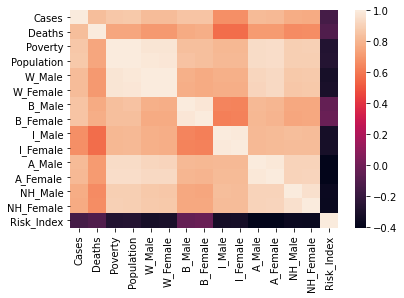

In [93]:
import seaborn as sns
sns.heatmap(all_data_5.corr())

A negative correlation was identified between 'Cases' and 'Risk Index' prompting the need to validate.

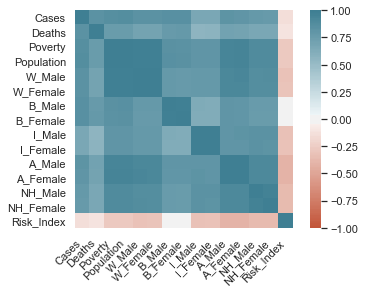

In [259]:
corr = all_data_5.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

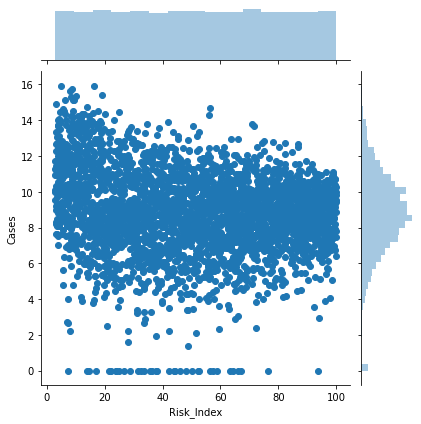

In [94]:
# sns.scatterplot(all_data_5["Risk_Index"], all_data_5["Cases"])

sns.jointplot(all_data_5["Risk_Index"], all_data_5["Cases"], data=all_data_5);


#### Plot 1. x = Risk Index (%); y = Cases (log)

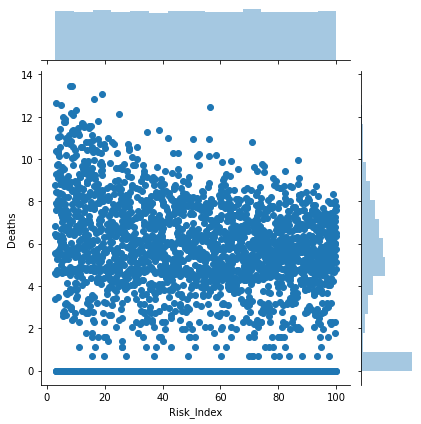

In [95]:
# sns.scatterplot(all_data_5["Risk_Index"], all_data_5["Deaths"])

sns.jointplot(all_data_5["Risk_Index"], all_data_5["Deaths"], data=all_data_5);

#### Plot 2. x = Risk Index (%); y = Deaths (log)

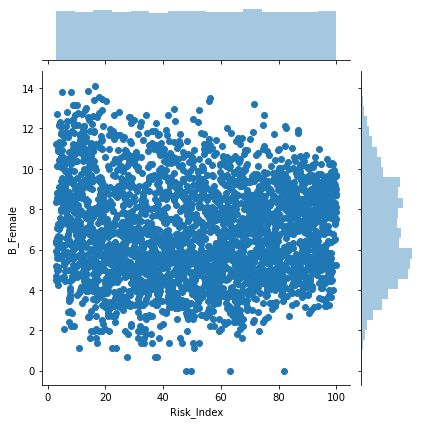

In [97]:
# sns.scatterplot(all_data_5["Risk_Index"], all_data_5["B_Female"])

sns.jointplot(all_data_5["Risk_Index"], all_data_5["B_Female"], data=all_data_5);

#### Plot 3. x = Risk Index (%); y = Black Females (log)

In [ ]:
# sns.scatterplot(all_data_5["Risk_Index"], all_data_5["Poverty"])

sns.jointplot(all_data_5["Risk_Index"], all_data_5["Poverty"], data=all_data_5);

#### Plot 4. x = Risk Index (%); y = Poverty (log)

In [ ]:
sns.distplot(all_data_5["Risk_Index"]);

#### Histogram 1. x = Risk Index (%)

In [ ]:
all_data_5.loc[:,["Risk_Index"]].describe()

#### Table. Risk Index Data Summary

In [ ]:
sns.scatterplot(all_data_5["Poverty"], all_data_5["Cases"])

#### Plot 5. x = Poverty (log); y = Cases (log)

In [226]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [227]:
fit1 = smf.ols("Cases ~ Poverty", data=all_data_5).fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     9190.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:19   Log-Likelihood:                -4977.7
No. Observations:                3142   AIC:                             9959.
Df Residuals:                    3140   BIC:                             9971.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0097      0.146    -34.377      0.000      -5.295      -4.724
Poverty        1.3498      0.014     95.867      0.000       1.322       1.377
==============================================================================
Omnibus:                      694.603   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5244.404
Skew:                          -0.843   Prob(JB):                         0.00
Kurtosis:                       9.101   Cond. No.                         72.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

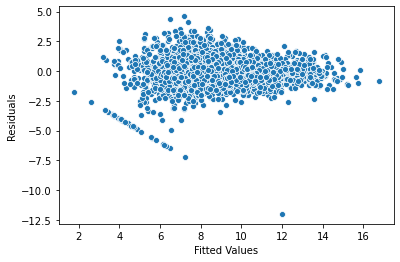

In [228]:
sns.scatterplot(fit1.fittedvalues, fit1.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [229]:
fit_all = smf.ols("Cases ~ Poverty + Population + W_Male + W_Female + B_Male + B_Female + I_Male + I_Female + A_Male + A_Female + NH_Male + NH_Female + Risk_Index", data=all_data_5).fit()

fit_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1049.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:20   Log-Likelihood:                -4489.3
No. Observations:                3142   AIC:                             9007.
Df Residuals:                    3128   BIC:                             9091.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4248      0.321    -10.664      0.000      -4.054      -2.795
Poverty       -0.2552      0.125     -2.045      0.041      -0.500      -0.011
Population     1.5773      0.182      8.649      0.000       1.220       1.935
W_Male        -0.3276      0.298     -1.101      0.271      -0.911       0.256
W_Female       0.0644      0.277      0.233      0.816      -0.479       0.608
B_Male         0.0516      0.049      1.064      0.287      -0.044       0.147
B_Female       0.3229      0.046      7.073      0.000       0.233       0.412
I_Male         0.0998      0.086      1.164      0.245      -0.068       0.268
I_Female      -0.1612      0.084     -1.920      0.055      -0.326       0.003
A_Male         0.1637      0.054      3.021      0.003       0.057       0.270
A_Female      -0.3103      0.059     -5.260      0.000      -0.426      -0.195
NH_Male        0.1142      0.035      3.307      0.001       0.046       0.182
NH_Female     -0.0989      0.035     -2.812      0.005      -0.168      -0.030
Risk_Index    -0.0021      0.001     -2.383      0.017      -0.004      -0.000
==============================================================================
Omnibus:                      531.457   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2981.469
Skew:                          -0.683   Prob(JB):                         0.00
Kurtosis:                       7.572   Cond. No.                     1.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

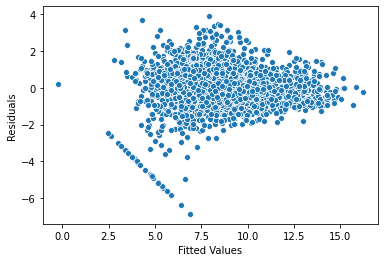

In [230]:
sns.scatterplot(fit_all.fittedvalues, fit_all.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [231]:
fit_cases_v1 = smf.ols("Cases ~ Poverty + W_Male + W_Female + B_Male + B_Female", data=all_data_5).fit()

fit_cases_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     2617.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:21   Log-Likelihood:                -4545.0
No. Observations:                3142   AIC:                             9102.
Df Residuals:                    3136   BIC:                             9138.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8462      0.169    -10.906      0.000      -2.178      -1.514
Poverty        0.4273      0.075      5.663      0.000       0.279       0.575
W_Male         0.4485      0.269      1.665      0.096      -0.080       0.976
W_Female      -0.1495      0.259     -0.577      0.564      -0.658       0.359
B_Male         0.1657      0.047      3.518      0.000       0.073       0.258
B_Female       0.3037      0.045      6.787      0.000       0.216       0.391
==============================================================================
Omnibus:                      568.279   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3166.251
Skew:                          -0.743   Prob(JB):                         0.00
Kurtosis:                       7.688   Cond. No.                         418.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
fit_cases_v2 = smf.ols("Cases ~ Poverty + B_Male + B_Female", data=all_data_5).fit()

fit_cases_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     4328.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:21   Log-Likelihood:                -4555.5
No. Observations:                3142   AIC:                             9119.
Df Residuals:                    3138   BIC:                             9143.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9963      0.161    -12.403      0.000      -2.312      -1.681
Poverty        0.7518      0.023     32.869      0.000       0.707       0.797
B_Male         0.2077      0.042      4.992      0.000       0.126       0.289
B_Female       0.2374      0.039      6.126      0.000       0.161       0.313
==============================================================================
Omnibus:                      685.824   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4469.156
Skew:                          -0.874   Prob(JB):                         0.00
Kurtosis:                       8.575   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
fit_cases_v3 = smf.ols("Cases ~ Poverty + W_Female + B_Female", data=all_data_5).fit()

fit_cases_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     4318.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:22   Log-Likelihood:                -4558.3
No. Observations:                3142   AIC:                             9125.
Df Residuals:                    3138   BIC:                             9149.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7889      0.168    -10.674      0.000      -2.117      -1.460
Poverty        0.4623      0.074      6.210      0.000       0.316       0.608
W_Female       0.2781      0.063      4.395      0.000       0.154       0.402
B_Female       0.4456      0.015     29.751      0.000       0.416       0.475
==============================================================================
Omnibus:                      552.790   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3184.706
Skew:                          -0.708   Prob(JB):                         0.00
Kurtosis:                       7.724   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
fit_cases_v4 = smf.ols("Cases ~ Poverty", data=all_data_5).fit()

fit_cases_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     9190.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:23   Log-Likelihood:                -4977.7
No. Observations:                3142   AIC:                             9959.
Df Residuals:                    3140   BIC:                             9971.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0097      0.146    -34.377      0.000      -5.295      -4.724
Poverty        1.3498      0.014     95.867      0.000       1.322       1.377
==============================================================================
Omnibus:                      694.603   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5244.404
Skew:                          -0.843   Prob(JB):                         0.00
Kurtosis:                       9.101   Cond. No.                         72.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [235]:
fit_cases_v5 = smf.ols("Cases ~ Risk_Index", data=all_data_5).fit()

fit_cases_v5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     70.05
Date:                Sun, 16 Aug 2020   Prob (F-statistic):           8.57e-17
Time:                        23:17:23   Log-Likelihood:                -7091.9
No. Observations:                3142   AIC:                         1.419e+04
Df Residuals:                    3140   BIC:                         1.420e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4457      0.086    109.807      0.000       9.277       9.614
Risk_Index    -0.0123      0.001     -8.370      0.000      -0.015      -0.009
==============================================================================
Omnibus:                      318.381   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.583
Skew:                          -0.668   Prob(JB):                    7.05e-133
Kurtosis:                       4.693   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
fit_cases_v5.params

Intercept     9.445743
Risk_Index   -0.012310
dtype: float64

In [239]:
fit_cases_v5.conf_int()

0         1
Intercept   9.277080  9.614406
Risk_Index -0.015194 -0.009427

In [240]:
err_series = fit_cases_v5.params - fit_cases_v5.conf_int()[0]
err_series

Intercept     0.168663
Risk_Index    0.002884
dtype: float64

In [241]:
coef_df = pd.DataFrame({'coef': fit_cases_v5.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
coef_df

coef       err     varname
0 -0.01231  0.002884  Risk_Index

<ipython-input-242-b5a7cddeee30>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


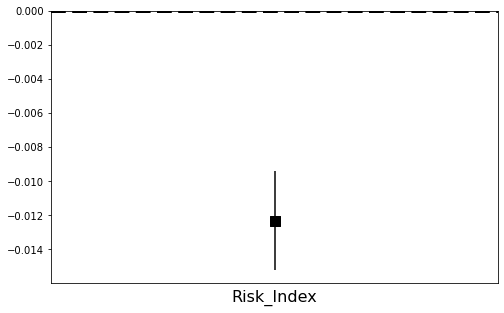

In [242]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Risk_Index'], 
                       rotation=0, fontsize=16)

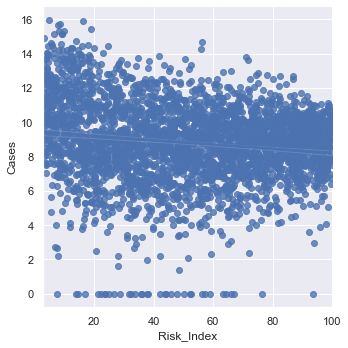

In [247]:
sns.set(color_codes=True)


sns.lmplot(x="Risk_Index", y="Cases", data=all_data_5);

In [237]:
fit_cases_v6 = smf.ols("Cases ~ W_Female + B_Female", data=all_data_5).fit()

fit_cases_v6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     6382.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:21:07   Log-Likelihood:                -4577.5
No. Observations:                3142   AIC:                             9161.
Df Residuals:                    3139   BIC:                             9179.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2315      0.142     -8.650      0.000      -1.511      -0.952
W_Female       0.6528      0.019     33.997      0.000       0.615       0.690
B_Female       0.5036      0.012     42.735      0.000       0.480       0.527
==============================================================================
Omnibus:                      483.303   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2798.518
Skew:                          -0.597   Prob(JB):                         0.00
Kurtosis:                       7.466   Cond. No.                         96.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [236]:
fit_deaths_v1 = smf.ols("Deaths ~ Poverty", data=all_data_5).fit()

fit_deaths_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     4092.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:17:24   Log-Likelihood:                -6837.9
No. Observations:                3142   AIC:                         1.368e+04
Df Residuals:                    3140   BIC:                         1.369e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4041      0.263    -47.088      0.000     -12.921     -11.888
Poverty        1.6280      0.025     63.965      0.000       1.578       1.678
==============================================================================
Omnibus:                       51.260   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.083
Skew:                          -0.272   Prob(JB):                     2.20e-11
Kurtosis:                       2.719   Cond. No.                         72.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
fit_deaths_v2 = smf.ols("Deaths ~ B_Male + B_Female", data=all_data_5).fit()

fit_deaths_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2411.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:41:25   Log-Likelihood:                -6686.6
No. Observations:                3142   AIC:                         1.338e+04
Df Residuals:                    3139   BIC:                         1.340e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8996      0.123    -23.524      0.000      -3.141      -2.658
B_Male         0.1801      0.080      2.240      0.025       0.022       0.338
B_Female       0.8562      0.076     11.278      0.000       0.707       1.005
==============================================================================
Omnibus:                       13.838   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.570
Skew:                          -0.141   Prob(JB):                      0.00113
Kurtosis:                       2.846   Cond. No.                         40.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
fit_deaths_v3 = smf.ols("Deaths ~ Cases + Poverty", data=all_data_5).fit()

fit_deaths_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     3591.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:42:33   Log-Likelihood:                -6278.4
No. Observations:                3142   AIC:                         1.256e+04
Df Residuals:                    3139   BIC:                         1.258e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.4473      0.259    -28.789      0.000      -7.954      -6.940
Cases          0.9895      0.027     36.644      0.000       0.937       1.042
Poverty        0.2925      0.042      6.928      0.000       0.210       0.375
==============================================================================
Omnibus:                       57.643   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.707
Skew:                          -0.304   Prob(JB):                     2.42e-14
Kurtosis:                       3.332   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
fit_deaths_v4 = smf.ols("Deaths ~ Cases + Risk_Index", data=all_data_5).fit()

fit_deaths_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     3517.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:39:26   Log-Likelihood:                -6301.4
No. Observations:                3142   AIC:                         1.261e+04
Df Residuals:                    3139   BIC:                         1.263e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.9791      0.147    -40.626      0.000      -6.268      -5.691
Cases          1.1537      0.014     83.131      0.000       1.126       1.181
Risk_Index     0.0016      0.001      1.340      0.180      -0.001       0.004
==============================================================================
Omnibus:                       63.223   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.605
Skew:                          -0.236   Prob(JB):                     9.48e-20
Kurtosis:                       3.668   Cond. No.                         271.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
fit_deaths_v5 = smf.ols("Deaths ~ Cases + Poverty + B_Male + B_Female", data=all_data_5).fit()

fit_deaths_v5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1918.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:39:27   Log-Likelihood:                -6205.0
No. Observations:                3142   AIC:                         1.242e+04
Df Residuals:                    3137   BIC:                         1.245e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0509      0.279    -21.710      0.000      -6.597      -5.504
Cases          0.8306      0.030     27.521      0.000       0.771       0.890
Poverty        0.1173      0.045      2.617      0.009       0.029       0.205
B_Male        -0.2563      0.071     -3.628      0.000      -0.395      -0.118
B_Female       0.5266      0.066      7.990      0.000       0.397       0.656
==============================================================================
Omnibus:                       49.966   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.991
Skew:                          -0.308   Prob(JB):                     5.13e-12
Kurtosis:                       3.134   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Coefficient Tree

In [210]:
fit_deaths_v5.params

Intercept   -6.050917
Cases        0.830609
Poverty      0.117345
B_Male      -0.256265
B_Female     0.526575
dtype: float64

In [212]:
fit_deaths_v5.conf_int()

0         1
Intercept -6.597397 -5.504438
Cases      0.771433  0.889786
Poverty    0.029430  0.205260
B_Male    -0.394750 -0.117781
B_Female   0.397363  0.655788

In [214]:
err_series = fit_deaths_v5.params - fit_deaths_v5.conf_int()[0]
err_series

Intercept    0.546479
Cases        0.059177
Poverty      0.087915
B_Male       0.138484
B_Female     0.129212
dtype: float64

In [216]:
coef_df = pd.DataFrame({'coef': fit_deaths_v5.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
coef_df

coef       err   varname
0  0.830609  0.059177     Cases
1  0.117345  0.087915   Poverty
2 -0.256265  0.138484    B_Male
3  0.526575  0.129212  B_Female

In [4]:
import seaborn as sns
sns.boxplot(data=coef_df, orient="h", palette="Set2")

NameError: name 'coef_df' is not defined

<ipython-input-219-693619b2b6c9>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


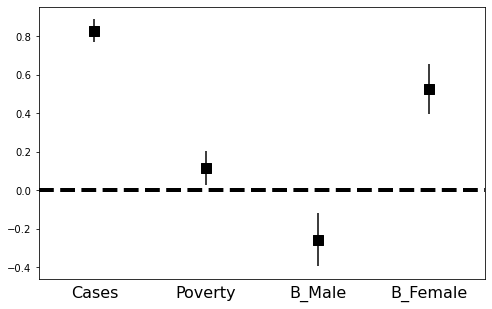

In [219]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Cases', 'Poverty', 'B_Male', 'B_Female'], 
                       rotation=0, fontsize=16)

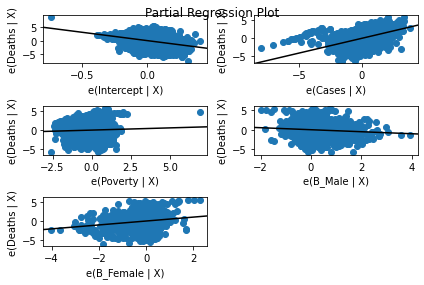

In [225]:
import statsmodels.api as sm

fig = sm.graphics.plot_partregress_grid(fit_deaths_v5)

## Model Option 2

In [122]:
fit_deaths_v6 = smf.ols("Deaths ~ Cases + Risk_Index + B_Male + B_Female", data=all_data_5).fit()

fit_deaths_v6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1914.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:39:28   Log-Likelihood:                -6207.2
No. Observations:                3142   AIC:                         1.242e+04
Df Residuals:                    3137   BIC:                         1.245e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.2769      0.154    -34.197      0.000      -5.580      -4.974
Cases          0.8607      0.027     32.074      0.000       0.808       0.913
Risk_Index    -0.0018      0.001     -1.534      0.125      -0.004       0.000
B_Male        -0.2375      0.070     -3.384      0.001      -0.375      -0.100
B_Female       0.5440      0.066      8.203      0.000       0.414       0.674
==============================================================================
Omnibus:                       47.432   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.297
Skew:                          -0.297   Prob(JB):                     1.97e-11
Kurtosis:                       3.154   Cond. No.                         305.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Next Steps

Once dataframe is pre-processed:

1. Short list features based on correlations analysis
2. Illustrate statistical outcomes with a summary table and data viz
3. Set-up data for Random Forest Model. 
4. Select features importance measures (out-of-bag=TRUE), look for variable importance results, test and evaluate.
5. Illustrate ML results with:
a) plot coefficient tree (illustating confident intervals) with significant features highlighted by line NOT crossing dot (look for the largest coefficient?); and,
b) Scatter plot, line and confidence band.

# Machine Learning

1. Random Forest Modeling (comparing all features versus high correlation features)
2. Importances measures? (https://machinelearningmastery.com/calculate-feature-importance-with-python/)
2. Access Out Of Bag Features (https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710)

## Version 1 (All Features): Feature & Target Selection

In [98]:
all_data_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FIPS           3142 non-null   object 
 1   stateFIPS      3142 non-null   object 
 2   countyFIPS_2d  3142 non-null   object 
 3   County         3142 non-null   object 
 4   State          3142 non-null   object 
 5   Cases          3142 non-null   int64  
 6   Deaths         3142 non-null   int64  
 7   Poverty        3142 non-null   float64
 8   Population     3142 non-null   float64
 9   W_Male         3142 non-null   float64
 10  W_Female       3142 non-null   float64
 11  B_Male         3142 non-null   float64
 12  B_Female       3142 non-null   float64
 13  I_Male         3142 non-null   float64
 14  I_Female       3142 non-null   float64
 15  A_Male         3142 non-null   float64
 16  A_Female       3142 non-null   float64
 17  NH_Male        3142 non-null   float64
 18  NH_Femal

In [127]:
y = all_data_4["Deaths"]

X = all_data_4.drop(["Deaths", "FIPS", "stateFIPS"
                     , "countyFIPS_2d", "County", "State", "Risk_Cat"],  axis=1)

X

Cases   Poverty  Population    W_Male  W_Female   B_Male  B_Female  \
0     39746   55073.0     55869.0   42250.0   43920.0  10751.0   12270.0   
1     76970  215255.0    223234.0  191540.0  202761.0  19832.0   21115.0   
2     24625   21979.0     24686.0   12906.0   11608.0  12743.0   11280.0   
3     13636   20212.0     22394.0   17635.0   16976.0   5951.0    3719.0   
4     19311   57238.0     57826.0   54866.0   56713.0   1174.0    1080.0   
...     ...       ...         ...       ...       ...      ...       ...   
3137   7361   42205.0     42343.0   41325.0   38927.0    828.0     640.0   
3138  13823   22888.0     23464.0   23328.0   21591.0    248.0     181.0   
3139   9737   20135.0     20226.0   19698.0   19209.0    199.0     186.0   
3140   3104    7735.0      7805.0    7602.0    7321.0     80.0      57.0   
3141    130    6595.0      6927.0    6867.0    6211.0     87.0      60.0   

      I_Male  I_Female  A_Male  A_Female  NH_Male  NH_Female  Risk_Index  
0      395.0     446.0   727.0     879.0     87.0       75.0       65.42  
1     2721.0    2624.0  2337.0    3394.0    254.0      267.0       68.39  
2      285.0     182.0   127.0     141.0     72.0       41.0       97.09  
3      159.0     151.0    72.0      73.0     50.0       16.0       83.36  
4      592.0     598.0   232.0     265.0    102.0       62.0       81.75  
...      ...       ...     ...       ...      ...        ...         ...  
3137   881.0     801.0   516.0     619.0     97.0       99.0       10.42  
3138   310.0     272.0   358.0     573.0     63.0       43.0        2.94  
3139   391.0     402.0   123.0     180.0     54.0       44.0       27.13  
3140   169.0     198.0    66.0     102.0     13.0       13.0       32.76  
3141   211.0     155.0    78.0     178.0      8.0        2.0       33.16  

[3142 rows x 14 columns]

## Train / Test Split

In [128]:
# train-test split
from sklearn.model_selection import train_test_split

# allocate 70% at random to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Select Algorhythm

In [129]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=10, oob_score=True, bootstrap=True)

## Final Model Evaluation

In [130]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, oob_score=True, random_state=10)

## Feature Importances

1. https://machinelearningmastery.com/calculate-feature-importance-with-python/
2. https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
3. https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

In [143]:
# feature_importances = pd.DataFrame(reg.feature_importances_,
#                                    index = X_train.columns,
#                                     columns=['importance']).sort_values('importance', ascending=False)

# feature_importances


# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Cases                Importance: 0.9
Variable: B_Male               Importance: 0.03
Variable: Population           Importance: 0.01
Variable: W_Female             Importance: 0.01
Variable: B_Female             Importance: 0.01
Variable: I_Male               Importance: 0.01
Variable: A_Female             Importance: 0.01
Variable: Risk_Index           Importance: 0.01
Variable: Poverty              Importance: 0.0
Variable: W_Male               Importance: 0.0
Variable: I_Female             Importance: 0.0
Variable: A_Male               Importance: 0.0
Variable: NH_Male              Importance: 0.0
Variable: NH_Female            Importance: 0.0


In [131]:
preds = reg.predict(X_test)

In [136]:
evaluate = pd.DataFrame({
    "actual" : y_test
    , "predicted" : preds
})

evaluate["error"] = evaluate["actual"] - evaluate["predicted"]

evaluate.head()

actual    predicted        error
2789       0  1297.015248 -1297.015248
2970     222  1297.015248 -1075.015248
1064     337  1297.015248  -960.015248
2895     338  1297.015248  -959.015248
2989    4095  1297.015248  2797.984752

In [132]:
import numpy as np

# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 2595.27 degrees.


In [133]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


## Version 1a (RF Most Important Features): Feature & Target Selection

Second attempt guided by feature importance data from Version 1.

In [145]:
y = all_data_4["Deaths"]

X = all_data_4.drop(["Deaths", "FIPS", "stateFIPS", "countyFIPS_2d", "County"
                     , "State", "Risk_Cat", "Poverty", "W_Male", "I_Female"
                    , "A_Male", "NH_Male", "NH_Female"],  axis=1)

X

Cases  Population  W_Female   B_Male  B_Female  I_Male  A_Female  \
0     39746     55869.0   43920.0  10751.0   12270.0   395.0     879.0   
1     76970    223234.0  202761.0  19832.0   21115.0  2721.0    3394.0   
2     24625     24686.0   11608.0  12743.0   11280.0   285.0     141.0   
3     13636     22394.0   16976.0   5951.0    3719.0   159.0      73.0   
4     19311     57826.0   56713.0   1174.0    1080.0   592.0     265.0   
...     ...         ...       ...      ...       ...     ...       ...   
3137   7361     42343.0   38927.0    828.0     640.0   881.0     619.0   
3138  13823     23464.0   21591.0    248.0     181.0   310.0     573.0   
3139   9737     20226.0   19209.0    199.0     186.0   391.0     180.0   
3140   3104      7805.0    7321.0     80.0      57.0   169.0     102.0   
3141    130      6927.0    6211.0     87.0      60.0   211.0     178.0   

      Risk_Index  
0          65.42  
1          68.39  
2          97.09  
3          83.36  
4          81.75  
...          ...  
3137       10.42  
3138        2.94  
3139       27.13  
3140       32.76  
3141       33.16  

[3142 rows x 8 columns]

In [146]:
# train-test split
from sklearn.model_selection import train_test_split

# allocate 70% at random to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [147]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=10, oob_score=True, bootstrap=True)

In [148]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, oob_score=True, random_state=10)

### Feature Importance

In [149]:
# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Cases                Importance: 0.88
Variable: B_Male               Importance: 0.04
Variable: B_Female             Importance: 0.02
Variable: A_Female             Importance: 0.02
Variable: Risk_Index           Importance: 0.02
Variable: Population           Importance: 0.01
Variable: I_Male               Importance: 0.01
Variable: W_Female             Importance: 0.0


### Prediction

In [150]:
preds = reg.predict(X_test)

### Evaluation

In [151]:
evaluate = pd.DataFrame({
    "actual" : y_test
    , "predicted" : preds
})

evaluate["error"] = evaluate["actual"] - evaluate["predicted"]

evaluate.head()

actual    predicted        error
2789       0  1297.015248 -1297.015248
2970     222  1297.015248 -1075.015248
1064     337  1297.015248  -960.015248
2895     338  1297.015248  -959.015248
2989    4095  1297.015248  2797.984752

In [152]:
# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 2594.23 degrees.


In [153]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


## Version 2 (Edited): Feature & Target Selection

### Select Features

In [188]:
all_data_6 = all_data_4.copy()

In [199]:
y = all_data_6["Deaths"]

X = all_data_6.drop(["Deaths", "FIPS", "stateFIPS", "Cases"
                     , "countyFIPS_2d", "County", "State", "Risk_Cat", "Population", "W_Male", "W_Female"
                     , "I_Male", "I_Female", "A_Male", "A_Female", "NH_Male", "NH_Female"],  axis=1)

X

Poverty   B_Male  B_Female  Risk_Index
0      55073.0  10751.0   12270.0       65.42
1     215255.0  19832.0   21115.0       68.39
2      21979.0  12743.0   11280.0       97.09
3      20212.0   5951.0    3719.0       83.36
4      57238.0   1174.0    1080.0       81.75
...        ...      ...       ...         ...
3137   42205.0    828.0     640.0       10.42
3138   22888.0    248.0     181.0        2.94
3139   20135.0    199.0     186.0       27.13
3140    7735.0     80.0      57.0       32.76
3141    6595.0     87.0      60.0       33.16

[3142 rows x 4 columns]

In [200]:
# train-test split
from sklearn.model_selection import train_test_split

# allocate 70% at random to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [201]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=10, oob_score=True, bootstrap=True)

### Fit Training Data

In [202]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, oob_score=True, random_state=10)

### Feature Importance

In [203]:
# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Poverty              Importance: 0.42
Variable: B_Female             Importance: 0.32
Variable: B_Male               Importance: 0.13
Variable: Risk_Index           Importance: 0.13


### Prediction

In [204]:
preds = reg.predict(X_test)

### Evaluation

In [205]:
evaluate = pd.DataFrame({
    "actual" : y_test
    , "predicted" : preds
})

evaluate["error"] = evaluate["actual"] - evaluate["predicted"]

evaluate.head()

actual    predicted        error
2789       0   972.789504  -972.789504
2970     222  1153.617469  -931.617469
1064     337   972.789504  -635.789504
2895     338   972.789504  -634.789504
2989    4095  1153.617469  2941.382531

In [206]:
# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3419.31 degrees.


In [207]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


## Version 3 (Cases): Feature & Target Selection

### Select Features

In [267]:
all_data_6 = all_data_4.copy()

In [269]:
y = all_data_6["Cases"]

X = all_data_6.drop(["Cases", "Deaths", "FIPS", "stateFIPS", "countyFIPS_2d", "County", "State", "Risk_Cat"],  axis=1)

X

Poverty  Population    W_Male  W_Female   B_Male  B_Female  I_Male  \
0      55073.0     55869.0   42250.0   43920.0  10751.0   12270.0   395.0   
1     215255.0    223234.0  191540.0  202761.0  19832.0   21115.0  2721.0   
2      21979.0     24686.0   12906.0   11608.0  12743.0   11280.0   285.0   
3      20212.0     22394.0   17635.0   16976.0   5951.0    3719.0   159.0   
4      57238.0     57826.0   54866.0   56713.0   1174.0    1080.0   592.0   
...        ...         ...       ...       ...      ...       ...     ...   
3137   42205.0     42343.0   41325.0   38927.0    828.0     640.0   881.0   
3138   22888.0     23464.0   23328.0   21591.0    248.0     181.0   310.0   
3139   20135.0     20226.0   19698.0   19209.0    199.0     186.0   391.0   
3140    7735.0      7805.0    7602.0    7321.0     80.0      57.0   169.0   
3141    6595.0      6927.0    6867.0    6211.0     87.0      60.0   211.0   

      I_Female  A_Male  A_Female  NH_Male  NH_Female  Risk_Index  
0        446.0   727.0     879.0     87.0       75.0       65.42  
1       2624.0  2337.0    3394.0    254.0      267.0       68.39  
2        182.0   127.0     141.0     72.0       41.0       97.09  
3        151.0    72.0      73.0     50.0       16.0       83.36  
4        598.0   232.0     265.0    102.0       62.0       81.75  
...        ...     ...       ...      ...        ...         ...  
3137     801.0   516.0     619.0     97.0       99.0       10.42  
3138     272.0   358.0     573.0     63.0       43.0        2.94  
3139     402.0   123.0     180.0     54.0       44.0       27.13  
3140     198.0    66.0     102.0     13.0       13.0       32.76  
3141     155.0    78.0     178.0      8.0        2.0       33.16  

[3142 rows x 13 columns]

In [270]:
# train-test split
from sklearn.model_selection import train_test_split

# allocate 70% at random to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [271]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=10, oob_score=True, bootstrap=True)

### Fitting Training Data

In [272]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, oob_score=True, random_state=10)

### Feature Importances

In [275]:
# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Poverty              Importance: 0.27
Variable: W_Female             Importance: 0.23
Variable: Population           Importance: 0.21
Variable: B_Male               Importance: 0.1
Variable: B_Female             Importance: 0.05
Variable: A_Female             Importance: 0.04
Variable: W_Male               Importance: 0.03
Variable: Risk_Index           Importance: 0.03
Variable: A_Male               Importance: 0.02
Variable: I_Male               Importance: 0.01
Variable: I_Female             Importance: 0.0
Variable: NH_Male              Importance: 0.0
Variable: NH_Female            Importance: 0.0


### Prediction

In [276]:
preds = reg.predict(X_test)

### Evaluation

In [277]:
evaluate = pd.DataFrame({
    "actual" : y_test
    , "predicted" : preds
})

evaluate["error"] = evaluate["actual"] - evaluate["predicted"]

evaluate.head()

actual     predicted         error
2789    1185  26023.198222 -24838.198222
2970   26095  42512.930505 -16417.930505
1064    1982  26023.198222 -24041.198222
2895   26281  26023.198222    257.801778
2989   56854  29814.881027  27039.118973

In [278]:
# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 54768.42 degrees.


In [279]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


## Version 3a (Cases; RF Most Important Features): Feature & Target Selection

### Select Features

In [282]:
y = all_data_6["Cases"]

X = all_data_6.drop(["Cases", "Deaths", "FIPS", "stateFIPS", "countyFIPS_2d"
                     , "County", "State", "Risk_Cat", "I_Male", "I_Female"
                     , "A_Male", "A_Female", "NH_Male", "NH_Female"],  axis=1)

X

Poverty  Population    W_Male  W_Female   B_Male  B_Female  Risk_Index
0      55073.0     55869.0   42250.0   43920.0  10751.0   12270.0       65.42
1     215255.0    223234.0  191540.0  202761.0  19832.0   21115.0       68.39
2      21979.0     24686.0   12906.0   11608.0  12743.0   11280.0       97.09
3      20212.0     22394.0   17635.0   16976.0   5951.0    3719.0       83.36
4      57238.0     57826.0   54866.0   56713.0   1174.0    1080.0       81.75
...        ...         ...       ...       ...      ...       ...         ...
3137   42205.0     42343.0   41325.0   38927.0    828.0     640.0       10.42
3138   22888.0     23464.0   23328.0   21591.0    248.0     181.0        2.94
3139   20135.0     20226.0   19698.0   19209.0    199.0     186.0       27.13
3140    7735.0      7805.0    7602.0    7321.0     80.0      57.0       32.76
3141    6595.0      6927.0    6867.0    6211.0     87.0      60.0       33.16

[3142 rows x 7 columns]

In [284]:
# train-test split
from sklearn.model_selection import train_test_split

# allocate 70% at random to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [285]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=10, oob_score=True, bootstrap=True)

### Fitting Training Data

In [286]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, oob_score=True, random_state=10)

### Feature Importances

In [287]:
# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Poverty              Importance: 0.36
Variable: W_Female             Importance: 0.24
Variable: Population           Importance: 0.17
Variable: B_Male               Importance: 0.09
Variable: B_Female             Importance: 0.07
Variable: Risk_Index           Importance: 0.04
Variable: W_Male               Importance: 0.03


### Prediction

In [288]:
preds = reg.predict(X_test)

### Evaluation

In [289]:
evaluate = pd.DataFrame({
    "actual" : y_test
    , "predicted" : preds
})

evaluate["error"] = evaluate["actual"] - evaluate["predicted"]

evaluate.head()

actual     predicted         error
2789    1185  25699.674861 -24514.674861
2970   26095  42189.407144 -16094.407144
1064    1982  25699.674861 -23717.674861
2895   26281  25699.674861    581.325139
2989   56854  29491.357666  27362.642334

In [290]:
# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 55109.98 degrees.


In [291]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


# Data Visualisation
1. Correlation Heatmap
2. Confidence Intervals: 
- https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/
- https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers
3. Scatter plot w/ line and confidence bands